# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Описание проекта
Заказчик этого исследования — сеть отелей «Как в гостях».  
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.  
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Описание данных
В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:
* `id` — номер записи;
* `adults` — количество взрослых постояльцев;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type` — тип заказчика:
    * `Contract` — договор с юридическим лицом;
    * `Group` — групповой заезд;
    * `Transient` — не связано с договором или групповым заездом;
    * `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_canceled` — отмена заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:
    * `SC` — нет дополнительных опций;
    * `BB` — включён завтрак;
    * `HB` — включён завтрак и обед;
    * `FB` — включён завтрак, обед и ужин.
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type` — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.

### План

1. Предобработка
2. Исследовательский анализ данных
3. Написание алгоритма подсчета выручки за год
4. Выбор и обучение модели
5. Расчет эффективности модели по выручке
6. Портрет "ненадежного" клиента

## Шаг 1. Откройте файлы с данными

In [1]:
PATH0 = 'datasets/hotel_train.csv'
PATH1 = 'datasets/hotel_test.csv'

In [2]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold



In [3]:
pd.set_option('display.max_columns', None) #Настроим пандас, чтобы показывал все столбцы
pd.set_option('display.max_rows', 1000) # ... выводил 1000 строк
pd.options.display.float_format = '{:,.4f}'.format # ... флоат значения с 4 знаками после запятой

In [4]:
rand_state = 12345
np.random.seed(rand_state)

In [5]:
data_train = pd.read_csv(PATH0,index_col=0)
data_test = pd.read_csv(PATH1,index_col=0)


In [6]:
data_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0,7.0000,2015,July,27,1,0,1,1.0000,0.0000,0.0000,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0000,2015,July,27,1,0,2,2.0000,0.0000,0.0000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0000,2015,July,27,1,0,2,2.0000,0.0000,0.0000,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0000,2015,July,27,1,0,2,2.0000,0.0000,0.0000,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0000,2015,July,27,1,0,3,2.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65229 entries, 0 to 84121
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_year               65229 non-null  int64  
 3   arrival_date_month              65229 non-null  object 
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  meal                            65229 non-null  object 
 12  country                         

In [8]:
data_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
id,,,,,,,,,,,,,,,,,,,,,,,,
6086,1,74.0000,2017,January,1,1,1,0,2.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
6087,1,62.0000,2017,January,1,1,2,2,2.0000,0.0000,0.0000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
6088,1,62.0000,2017,January,1,1,2,2,2.0000,0.0000,0.0000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
6089,1,71.0000,2017,January,1,1,2,2,1.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
6090,1,172.0000,2017,January,1,1,2,5,2.0000,0.0000,0.0000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32412 entries, 6086 to 97903
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     32412 non-null  int64  
 1   lead_time                       32412 non-null  float64
 2   arrival_date_year               32412 non-null  int64  
 3   arrival_date_month              32412 non-null  object 
 4   arrival_date_week_number        32412 non-null  int64  
 5   arrival_date_day_of_month       32412 non-null  int64  
 6   stays_in_weekend_nights         32412 non-null  int64  
 7   stays_in_week_nights            32412 non-null  int64  
 8   adults                          32412 non-null  float64
 9   children                        32412 non-null  float64
 10  babies                          32412 non-null  float64
 11  meal                            32412 non-null  object 
 12  country                      

**Вывод**: 
* Явных пропусков нет
* Тип данных, в целом, подходящий.

## Предобработка данных

In [10]:
data_train.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights'],
      dtype='object')

In [11]:
# cols = ['babies','country','previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']
# for column in cols:
#     print(column + " start")
#     display(data_train[column].value_counts())
#     print(column + " END")
#     print()
#     print()    

In [12]:
# for column in data_full.columns:
#     print(column + " start")
#     display(data_full[column].value_counts())
#     print()
#     display(data_full[column].unique())
#     print(column + " END")
#     print()
#     print()
    
# # babies,countries,previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, required_car_parking_spaces, total_of_special_requests 

Нужно почистить некоторые столбцы со строками.

### 'meal'

In [13]:
data_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [14]:
data_test['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

In [15]:
data_train['meal'] = data_train['meal'].str.strip()
data_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [16]:
data_test['meal'] = data_test['meal'].str.strip()
data_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

### 'reserved_room_type'

In [17]:
data_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [18]:
data_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

In [19]:
data_train['reserved_room_type'] = data_train['reserved_room_type'].str.strip()
data_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [20]:
data_test['reserved_room_type'] = data_test['reserved_room_type'].str.strip()
data_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

### 'arrival_date_month'

Изменим тип данных на категориальный, чтобы удобнее было сортировать по месяцам в дальнейшем.

In [21]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November',
          'December']
data_train['arrival_date_month'] = pd.Categorical(data_train['arrival_date_month'],ordered=True,categories=months)
data_test['arrival_date_month'] = pd.Categorical(data_test['arrival_date_month'],ordered=True,categories=months)

### Поиск и обработка дубликатов

In [22]:
def del_dups(df):
    print('Кол-во дубликатов, было:',df.duplicated().sum())
    print('Доля дубликатов, было:',df.duplicated().mean())
    print('Размерность, было:', df.shape)
    df = df.drop_duplicates()
    print('Доля дубликатов, стало:',df.duplicated().mean())
    print('Кол-во дубликатов, стало:',df.duplicated().sum())
    print('Размерность, стало:', df.shape)
    return df

In [23]:
data_train = del_dups(data_train)

Кол-во дубликатов, было: 21377
Доля дубликатов, было: 0.3277223320915544
Размерность, было: (65229, 24)
Доля дубликатов, стало: 0.0
Кол-во дубликатов, стало: 0
Размерность, стало: (43852, 24)


In [24]:
data_test = del_dups(data_test)

Кол-во дубликатов, было: 7717
Доля дубликатов, было: 0.23809083055658398
Размерность, было: (32412, 24)
Доля дубликатов, стало: 0.0
Кол-во дубликатов, стало: 0
Размерность, стало: (24695, 24)


**Выводы**
* В data_train было 21377 (33%) дубликатов, удалены.
* В data_test - 7717 (24%).

## Исследовательский анализ данных

Нам необходимо проанализировать данные, чтобы:
1. Составить портрет клиента/заказа склонного к отмене
2. Выбрать признаки, подходящие для модели и не искажающие результат
3. Обнаружить аномалии и зависимости

### План и функции

В целом будем использовать 4 типа анализа в подходящих признаках:
* Univariate non-graphical EDA
    * Чиловое описание признака 
* Univariate graphical EDA
    * Графическое
* Multivariate non-graphical EDA
    * Числовое описание зависимости признака и таргета
* Multivariate graphical EDA
    * Графическое -//-
    
Нам понадобятся следующие функции:

* Univariate non-graphical EDA
    Для категориальных данных: диапазон и частота
    Для колличественных: меры центральной тенденции (Среднее, медиана, мода), разброс (дисперсия, стнд. отклонение, разброс), модальность (количество пиков), форма и выбросы (доп: скошенность (мера ассиметрии), Куртосис (measure of peakedness relative to a Gaussian shape)
* Univariate graphical EDA
    Типы графиков: гистограмма, ящик с усами, qqplots
* Multivariate non-graphical EDA
    Зависимость между несколькими (обычно двумя) признаками. Чаще это 
    признак и таргет. 
* Multivariate graphical EDA
    Категориальные: барплот, ящики с усами
    Количественные: график рассеяния

In [25]:
def univ_quant_describe(df,column):
    """
    Числовое описание 1 колличественного признака.
    """
#     Подсчет количества значений
    count_ = df[column].count()
    
#     Меры центральной тенденции:
#     Среднее
    mean = df[column].mean()
#     Медиана
    median = df[column].median()
#     Мода
    mode = df[column].mode()

#     Меры разброса
#     Дисперсия
    var = df[column].var()
#     Стандартное отклонение
    stddev = df[column].std()
#     Межквартильный размах
    quartile_1 = df[column].quantile(0.25)
    quartile_3 = df[column].quantile(0.75)
    iqr = quartile_3 - quartile_1
#     Мин, макс, размах
    min_ = df[column].min()
    max_ = df[column].max()
    range_ = max_ - min_

#     Левая граница ящика с усами
    outlier_border_left = quartile_1 - 1.5 * iqr
#     Правая граница ящика с усами
    outlier_border_right = quartile_3 + 1.5 * iqr
    
#    Количество выбросов
    outliers_mask = (df[column] < outlier_border_left) | (df[column] > outlier_border_right)
    outliers_count = df.loc[outliers_mask,column].count()
    outliers_proportion = outliers_count / count_
    
#     Создание и вывод таблицы с числовым описанием данных
    describe_ = {"count": count_,
                 "mean": mean,
                 "mode": mode,
                 "var": var,
                 "stddev": stddev,
                 "min": min_,
                 "25%": quartile_1,
                 "50%": median,
                 "75%": quartile_3,
                 "max": max_,
                 "total_range": range_,
                 "interquartile_range": iqr,
                 "outlier_border_left": outlier_border_left,
                 "outlier_border_right": outlier_border_right,
                 "outliers_count": outliers_count,
                 "outliers_proportion": outliers_proportion}
    describe_ = pd.DataFrame(describe_).transpose()
    describe_.columns = [column]
    with pd.option_context("display.float_format", '{:.3f}'.format):
                           display(describe_)
            
# univ_quant_describe(data_train,'lead_time')

In [26]:
def univ_cat_describe(df,column,sort=False):
    """
    Числовое описание 1 категориального признака
    (.value_counts() + .value_counts(normalize=True)
    """
    vc1 = df[column].value_counts(sort=sort)
    vc2 = df[column].value_counts(normalize=True)
#     print(vc1,vc2)
    result = pd.concat([vc1,vc2],axis=1)
    result.columns = ['count','proportion']
    result.index.name = 'value'
#     if sort == True:
#         result.sort_values(by='count')
    return result

# univ_cat_describe(data_train,'meal',sort=False)

In [27]:
def multi_crosstab(df,column,normalize=True):
    '''
    Числовое описание каждого значения признака (категориального или численного),
    поделенное на подгруппу с таргет==1 и таргет==0.
    С подсчетом разнизы между подгруппами.
    
    Если normalize=True, то в итоговой таблице выводятся значения нормализованные по подгруппе.
    Т.е. в подгруппе всего признака (всех значений) по таргету==1 - 100% наблюдений.
    А например в категории А этого признака, подгруппы по таргету==1, например 10%
    Если в категории А по таргету==1 - 10% значений, а в этой же категории по таргету==0 - 12%, то разница будет в 2%
    '''
#     
    if normalize == True:
        normalize = 'columns'
    crst = pd.crosstab(df[column],df['is_canceled'],normalize=normalize)
    crst['diff'] = crst[1] - crst[0]
    crst = crst.transpose()
    if normalize == 'columns':
        return crst.style.format('{:,.2%}')
    return crst

# def multi_crosstab2(df,column):

#     crst = pd.crosstab(df[column],df['is_canceled'])
#     crst['diff'] = crst[1] - crst[0]
#     crst_n = pd.crosstab(df[column],df['is_canceled'],normalize=True)
#     crst_n['diff'] = crst_n[1] - crst_n[0]  
#     crst.columns = ['0_count','1_count','diff_count']
#     crst_n.columns = ['0_%','1_%','diff_%']
# #     crst_n = crst_n.apply('{:.0%}'.format)
# #     display(crst,crst_n)
#     result = pd.concat([crst,crst_n],axis=1)
#     result = result[['0_count','0_%','1_count','1_%','diff_count','diff_%']]
# #     result = result.transpose()
# #     display(result)
# #     dic = {'0_%':'{:,.2%}','1_%':'{:,.2%}','diff_%':'{:,.2%}'}
# #     return result.style.format(dic)
# #     return result.style.format('{:,.2%}',subset=pd.IndexSlice[['0_%','1_%','diff_%'], :])
#     return result

    
# multi_crosstab(data_full,'total_nights',normalize=False)
# multi_crosstab(data_full,'lead_time')
# display(pd.crosstab(data_full['is_canceled'],data_full['stays_in_week_nights'],normalize=True,margins=True))
# multi_crosstab2(data_full,'stays_in_week_nights')

In [28]:
def univ_hist(df,column,bins=False,xlabel=None,figsize=(10,5)):
    """
    Построение гистограммы
    """
    
    if bins == False:
        bins=df[column].nunique()
        
    fig,ax = plt.subplots(figsize=figsize)
    ax.hist(df[column],bins=bins)
    ax.set_ylabel('Частота')
    
    if xlabel == None:
        ax.set_xlabel(df[column].name)
    else:
        ax.set_xlabel(xlabel)
    return fig,ax
    
    
# univ_hist(data_train,'lead_time',bins=30,xlabel="Дней")
    

In [29]:
def univ_hist_box(df,column,bins=False,xlabel=None,figsize=(10,5)):
    """
    Построение гистограммы с ящиком с усами
    """
    
    if bins == False:
        bins=df[column].nunique()
        
    fig,ax = plt.subplots(figsize=figsize)
    ax.hist(df[column],bins=bins)
    ax2=ax.twinx()
    ax2.boxplot(df[column],vert=False)
    ax.set_ylabel('Частота')
    
    if xlabel == None:
        ax.set_xlabel(df[column].name)
    else:
        ax.set_xlabel(xlabel)
    return fig,ax,ax2
    
    
# univ_hist_box(data_train,'lead_time',bins=30,xlabel="Дней")

In [30]:
def multiv_target_hist_normalized(df,column,bins=False,xlabel=None,figsize=(10,5)):
    """
    Построение двух полупрозрачных нормализованных гистограмм (с функцией плотности) на одной фигуре.
    Каждая гистограмма это подгруппа признака по таргету.
    
    """
    
    canceled = data_train.loc[df['is_canceled'] == 1, column].sort_values()
    not_canceled = data_train.loc[df['is_canceled'] == 0, column].sort_values()
    
    fig,ax = plt.subplots(figsize=figsize)
    
    if bins == False:
        bins = df[column].nunique()
        
    ax.hist(canceled,bins=bins,alpha=0.5,label=['canceled'],density=True)
    ax.hist(not_canceled,bins=bins,alpha=0.5,label=['not_canceled'],density=True)
    ax.set_ylabel('Частота')
    if xlabel == None:
        ax.set_xlabel(df[column].name)
    else:
        ax.set_xlabel(xlabel)
    ax.legend()
    return fig,ax
    
# multiv_target_hist_normalized(data_train,'lead_time',bins=30,xlabel='Дней')
# multiv_target_hist_normalized(data_full,'lead_time',bins=False,xlabel='Дней от даты бронирования до заезда')


In [31]:
def univ_bar(df,column,xlabel=None,sort_index=False,figsize=(10,5)):
    """
    Построение барплота для одного признака
    """
    vc = df[column].value_counts()
    
    if sort_index == True:
        vc = vc.sort_index()
        
    fig,ax = plt.subplots(figsize=figsize)
    ax.bar(vc.index,vc)
    ax.set_ylabel('Частота')
    
    if xlabel == None:
        ax.set_xlabel(df[column].name)
    else:
        ax.set_xlabel(xlabel)
        
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    return fig,ax
    
    
# univ_bar(data_train,'is_canceled',xlabel="Дней")

In [32]:
def multiv_target_bar_normalized(df,column,sort=False,sort_index=False,xlabel=None,figsize=(10,5)):
    """
    Построение двух полупрозрачных барплотов по нормализованным значениям на одной фигуре.
    """
    canceled = df.loc[df['is_canceled'] == 1, column].sort_values()
    not_canceled = df.loc[df['is_canceled'] == 0, column].sort_values()
    
    can_vc = canceled.value_counts(sort=sort,normalize=True)
    ncan_vc = not_canceled.value_counts(sort=sort,normalize=True)
    
    if sort_index == True:
        can_vc = can_vc.sort_index()
        ncan_vc = ncan_vc.sort_index()
    
    fig,ax = plt.subplots(figsize=figsize)
    
    ax.bar(x=can_vc.index,height=can_vc,alpha=0.5,label=['canceled'])
    ax.bar(x=ncan_vc.index,height=ncan_vc,alpha=0.5,label=['not_canceled'])
        
    ax.set_ylabel('Доля от всех наблюдений этой категории')
    if xlabel == None:
        ax.set_xlabel(df[column].name)
    else:
        ax.set_xlabel(xlabel)
        
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend()
    return fig,ax
    

# multiv_target_bar_normalized(data_train,'meal',xlabel='Дней')


### Анализ

Объединим датасеты для анализа всей информации, что у нас есть. И постараемся не допустить утечки таргета, если какие-то выводы попадут в модель.

In [33]:
data_train['is_test'] = 0
# data_train['is_test']
data_test['is_test'] = 1
# data_test['is_test']

data_full = pd.concat([data_train,data_test])
data_full

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,is_test
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,7.0000,2015,July,27,1,0,1,1.0000,0.0000,0.0000,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1,0
1,0,14.0000,2015,July,27,1,0,2,2.0000,0.0000,0.0000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2,0
2,0,0.0000,2015,July,27,1,0,2,2.0000,0.0000,0.0000,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2,0
3,0,9.0000,2015,July,27,1,0,2,2.0000,0.0000,0.0000,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2,0
4,1,85.0000,2015,July,27,1,0,3,2.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97899,0,164.0000,2017,August,35,31,2,4,2.0000,0.0000,0.0000,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1
97900,0,21.0000,2017,August,35,30,2,5,2.0000,0.0000,0.0000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1
97901,0,23.0000,2017,August,35,30,2,5,2.0000,0.0000,0.0000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1


#### Изучение целевого признака 'is_canceled'

In [34]:
univ_cat_describe(data_full,'is_canceled')

,count,proportion
value,,
0,49614,0.7238
1,18933,0.2762


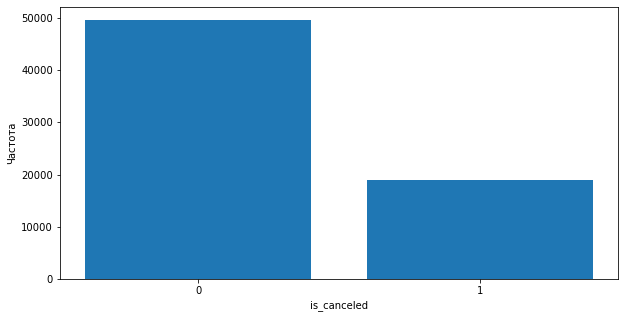

In [35]:
univ_bar(data_full,'is_canceled');

In [36]:
data_full.corr()[['is_canceled']]

,is_canceled
is_canceled,1.0000
lead_time,0.2017
arrival_date_year,0.0792
arrival_date_week_number,0.0021
arrival_date_day_of_month,0.0052
stays_in_weekend_nights,0.0402
stays_in_week_nights,0.0761
adults,0.0834
children,0.0457
babies,-0.0223


**Вывод**
* Дисбаланс целевого признака
* Отметим относительно высокую корреляцию с `'lead_time'`,`'previous_cancellations'`,`'booking_changes'`,`'required_car_parking_spaces'`,`'total_of_special_requests'`.

#### 'lead_time'

In [37]:
univ_quant_describe(data_full,'lead_time')

,lead_time
count,68547.000
mean,75.438
mode,0.000
var,6237.309
stddev,78.977
min,0.000
25%,11.000
50%,47.000
75%,118.000
max,374.000


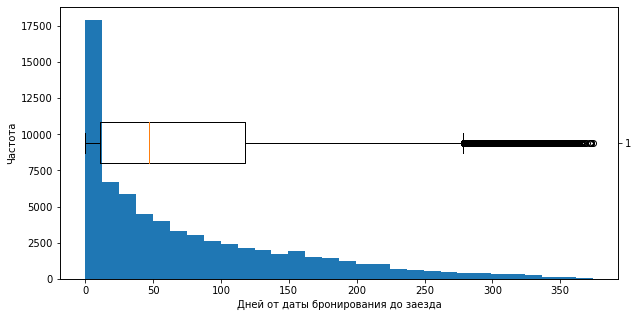

In [38]:
univ_hist_box(data_full,'lead_time',bins=30,xlabel='Дней от даты бронирования до заезда')
plt.show()

In [39]:
# pd.crosstab(data_full['is_canceled'],data_full['lead_time'])
# multi_crosstab(data_full,'lead_time')

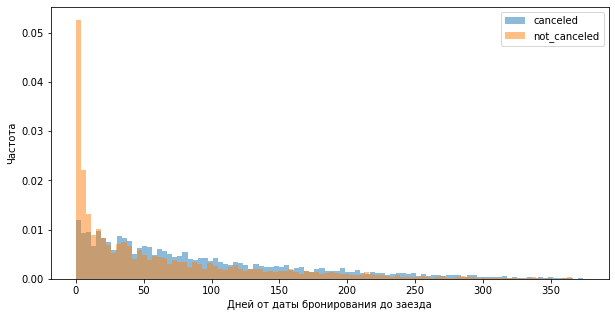

In [40]:
multiv_target_hist_normalized(data_full,'lead_time',bins=100,xlabel='Дней от даты бронирования до заезда')
plt.show()

**Вывод**
* Где-то до 20 дней шанс отмены значительно ниже
* От 20 и далее шанс отмены чуть выше.
* Выбросов (>278 дней) 1796 (2,6%)

#### Изучение дат

**'arrival_date_year'**

In [41]:
univ_cat_describe(data_full,'arrival_date_year')

,count,proportion
value,,
2015,9844,0.1436
2016,34008,0.4961
2017,24695,0.3603


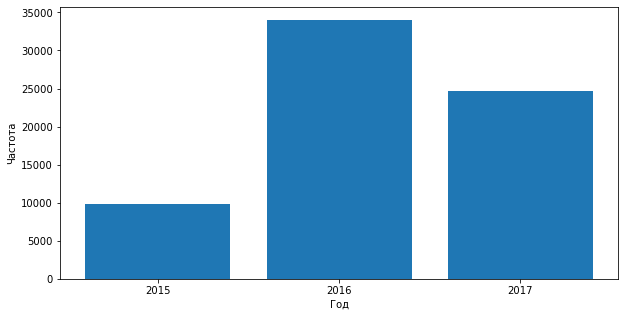

In [42]:
univ_bar(data_full,'arrival_date_year',xlabel='Год')
plt.show()

In [43]:
multi_crosstab(data_full,'arrival_date_year')

arrival_date_year,2015,2016,2017
is_canceled,,,
0,15.72%,50.19%,34.08%
1,10.79%,48.09%,41.12%
diff,-4.93%,-2.10%,7.04%


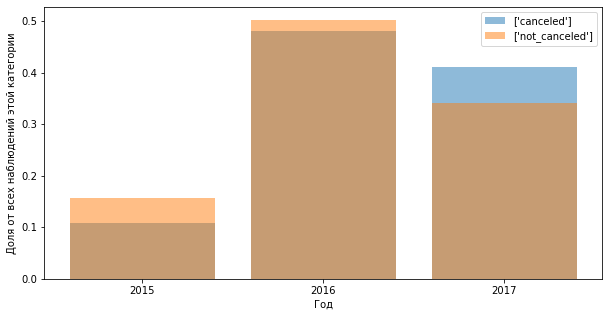

In [44]:
multiv_target_bar_normalized(data_full,'arrival_date_year',xlabel='Год')
plt.show()

**'arrival_date_month'**

In [45]:
univ_cat_describe(data_full,'arrival_date_month')

,count,proportion
value,,
January,3839,0.0560
February,5068,0.0739
March,6397,0.0933
April,6645,0.0969
May,6826,0.0996
June,6162,0.0899
July,7204,0.1051
August,7446,0.1086
September,5212,0.0760


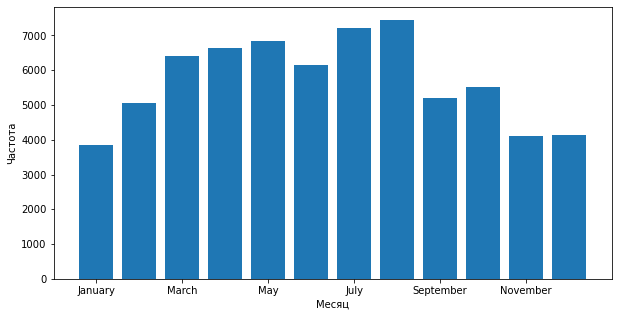

In [46]:
univ_bar(data_full,'arrival_date_month',sort_index=True,xlabel='Месяц')
plt.show()

In [47]:
multi_crosstab(data_full,'arrival_date_month')

arrival_date_month,January,February,March,April,May,June,July,August,September,October,November,December
is_canceled,,,,,,,,,,,,
0,6.02%,7.86%,9.66%,9.22%,9.66%,8.62%,9.92%,10.33%,7.82%,8.37%,6.48%,6.05%
1,4.49%,6.17%,8.48%,10.94%,10.74%,9.97%,12.06%,12.27%,7.02%,7.19%,4.67%,5.99%
diff,-1.53%,-1.69%,-1.17%,1.73%,1.08%,1.35%,2.14%,1.94%,-0.80%,-1.18%,-1.80%,-0.05%


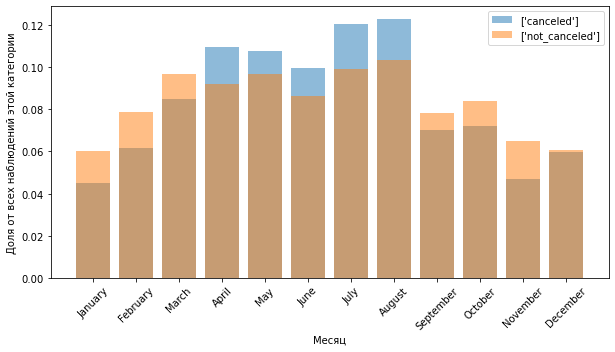

In [48]:
fig,ax = multiv_target_bar_normalized(data_full,'arrival_date_month',sort_index=True,xlabel='Месяц')
ax.set_xticks(data_full['arrival_date_month'].unique())
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

**'arrival_date_week_number'**

In [49]:
univ_cat_describe(data_full,'arrival_date_week_number')

,count,proportion
value,,
1,733,0.0107
2,797,0.0116
3,827,0.0121
4,911,0.0133
5,892,0.0130
6,1066,0.0156
7,1383,0.0202
8,1260,0.0184
9,1332,0.0194


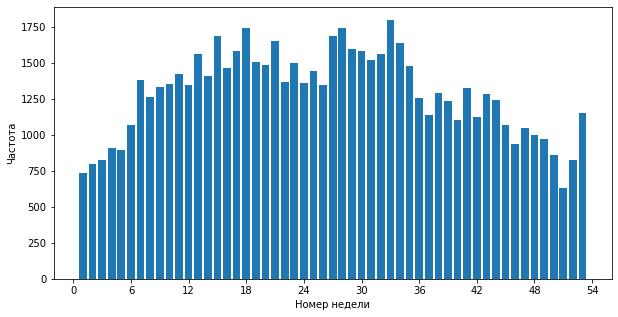

In [50]:
univ_bar(data_full,'arrival_date_week_number',xlabel='Номер недели')
plt.show()

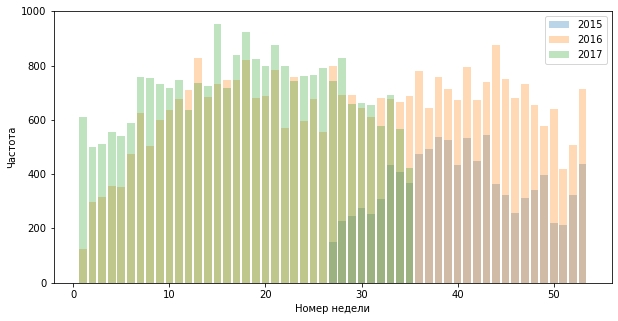

In [51]:
fig,ax = plt.subplots(figsize=(10,5))

for name, group in data_full[['arrival_date_year','arrival_date_week_number']].groupby('arrival_date_year'):
    vc = group['arrival_date_week_number'].value_counts()
    ax.bar(vc.index,vc,alpha=0.3,label=name)
    
ax.set_ylabel('Частота')
ax.set_xlabel('Номер недели')
ax.legend()
plt.show()

In [52]:
multi_crosstab(data_full,'arrival_date_week_number')

arrival_date_week_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.05%,1.26%,1.30%,1.49%,1.39%,1.67%,2.13%,1.93%,2.08%,2.04%,2.16%,2.05%,2.32%,2.02%,2.33%,2.00%,2.25%,2.30%,2.10%,2.16%,2.31%,1.98%,2.17%,1.93%,2.02%,1.85%,2.30%,2.35%,2.24%,2.18%,2.08%,2.14%,2.45%,2.34%,2.09%,1.87%,1.67%,1.97%,1.88%,1.63%,1.98%,1.80%,1.90%,1.87%,1.70%,1.48%,1.66%,1.56%,1.46%,1.25%,1.00%,1.26%,1.56%
1,1.11%,0.91%,0.96%,0.92%,1.06%,1.24%,1.72%,1.58%,1.57%,1.80%,1.86%,1.73%,2.17%,2.14%,2.79%,2.49%,2.48%,3.19%,2.43%,2.20%,2.69%,2.05%,2.24%,2.11%,2.32%,2.27%,2.89%,3.07%,2.55%,2.62%,2.57%,2.65%,3.07%,2.52%,2.31%,1.73%,1.64%,1.66%,1.61%,1.55%,1.81%,1.21%,1.80%,1.66%,1.20%,1.08%,1.19%,1.18%,1.32%,1.28%,0.72%,1.08%,2.00%
diff,0.06%,-0.34%,-0.34%,-0.57%,-0.34%,-0.43%,-0.42%,-0.35%,-0.51%,-0.24%,-0.30%,-0.32%,-0.16%,0.13%,0.47%,0.48%,0.24%,0.89%,0.33%,0.04%,0.38%,0.07%,0.06%,0.18%,0.30%,0.42%,0.59%,0.72%,0.31%,0.43%,0.49%,0.50%,0.62%,0.18%,0.22%,-0.14%,-0.03%,-0.31%,-0.27%,-0.08%,-0.17%,-0.59%,-0.11%,-0.21%,-0.50%,-0.39%,-0.47%,-0.38%,-0.14%,0.03%,-0.29%,-0.18%,0.44%


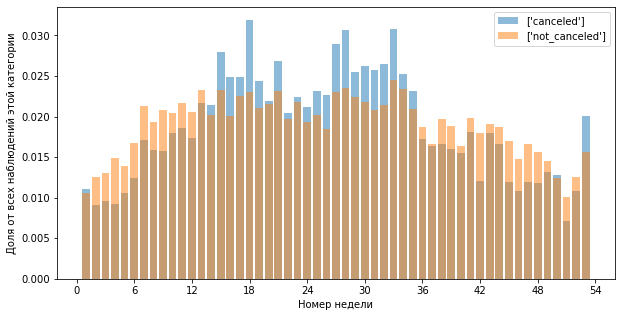

In [53]:
multiv_target_bar_normalized(data_full,'arrival_date_week_number',xlabel='Номер недели')
plt.show()

**'arrival_date_day_of_month'**

In [54]:
univ_cat_describe(data_full,'arrival_date_day_of_month')

,count,proportion
value,,
1,2105,0.0307
2,2402,0.0350
3,2258,0.0329
4,2191,0.0320
5,2351,0.0343
6,2207,0.0322
7,2141,0.0312
8,2227,0.0325
9,2303,0.0336


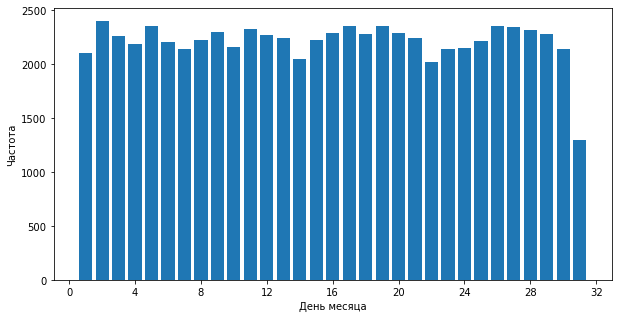

In [55]:
univ_bar(data_full,'arrival_date_day_of_month',xlabel='День месяца')
plt.show()

In [56]:
multi_crosstab(data_full,'arrival_date_day_of_month')

arrival_date_day_of_month,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.03%,3.53%,3.28%,3.21%,3.50%,3.27%,3.08%,3.19%,3.37%,3.17%,3.37%,3.37%,3.28%,3.04%,3.23%,3.31%,3.36%,3.38%,3.56%,3.44%,3.34%,2.88%,3.19%,3.09%,3.27%,3.35%,3.32%,3.34%,3.28%,3.04%,1.93%
1,3.18%,3.44%,3.34%,3.17%,3.24%,3.08%,3.24%,3.41%,3.34%,3.11%,3.47%,3.18%,3.27%,2.87%,3.26%,3.40%,3.64%,3.17%,3.10%,3.06%,3.13%,3.13%,2.94%,3.27%,3.12%,3.65%,3.71%,3.50%,3.45%,3.32%,1.78%
diff,0.15%,-0.09%,0.07%,-0.04%,-0.26%,-0.19%,0.17%,0.23%,-0.03%,-0.06%,0.10%,-0.19%,-0.01%,-0.16%,0.03%,0.09%,0.28%,-0.22%,-0.47%,-0.39%,-0.20%,0.25%,-0.25%,0.18%,-0.15%,0.31%,0.40%,0.17%,0.17%,0.28%,-0.15%


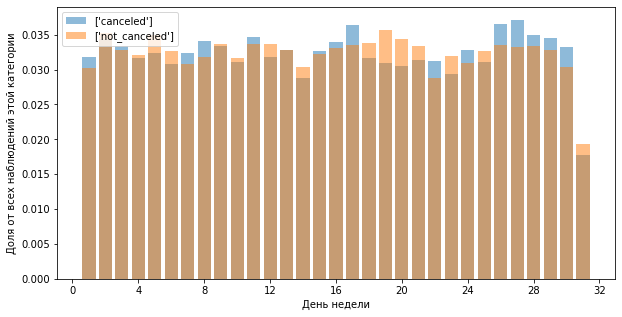

In [57]:
multiv_target_bar_normalized(data_full,'arrival_date_day_of_month',xlabel='День недели')
plt.show()

**Создание новых признаков - даты ордера**

**'order_date'**

In [58]:
var1 = pd.to_datetime(data_full[['arrival_date_year','arrival_date_month','arrival_date_day_of_month']].astype(str).apply(lambda x: '-'.join(x),axis=1),format="%Y-%B-%d")
var2 = pd.to_timedelta(data_full['lead_time'],unit='D')

data_full['order_date'] = var1 - var2

del var1
del var2

data_full['order_date'].head()

id
0   2015-06-24
1   2015-06-17
2   2015-07-01
3   2015-06-22
4   2015-04-07
Name: order_date, dtype: datetime64[ns]

In [59]:
data_full['order_date_month'] = data_full['order_date'].dt.month_name()
data_full['order_date_day_of_month'] = data_full['order_date'].dt.day
data_full['order_date_week_number'] = data_full['order_date'].dt.week

<ipython-input-59-359c000a27f6>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_full['order_date_week_number'] = data_full['order_date'].dt.week


In [60]:
data_full.iloc[:,-4:].head()

,order_date,order_date_month,order_date_day_of_month,order_date_week_number
id,,,,
0,2015-06-24,June,24,26
1,2015-06-17,June,17,25
2,2015-07-01,July,1,27
3,2015-06-22,June,22,26
4,2015-04-07,April,7,15


**'order_date_month'**

In [61]:
data_full['order_date_month'] = pd.Categorical(data_full['order_date_month'],ordered=True,categories=months)

In [62]:
univ_cat_describe(data_full,'order_date_month')

,count,proportion
value,,
January,10416,0.1520
February,8805,0.1285
March,6443,0.0940
April,5313,0.0775
May,4933,0.0720
June,3681,0.0537
July,4070,0.0594
August,4917,0.0717
September,5184,0.0756


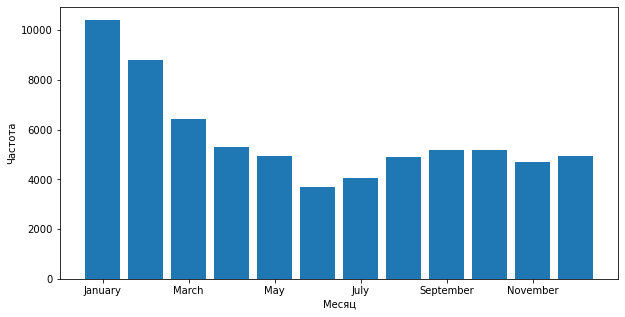

In [63]:
univ_bar(data_full,'order_date_month',xlabel='Месяц',sort_index=True)
plt.show()

In [64]:
multi_crosstab(data_full,'order_date_month')

order_date_month,January,February,March,April,May,June,July,August,September,October,November,December
is_canceled,,,,,,,,,,,,
0,15.20%,12.77%,9.39%,7.54%,7.12%,5.35%,5.80%,7.36%,7.77%,7.54%,6.89%,7.26%
1,15.20%,13.04%,9.41%,8.30%,7.40%,5.43%,6.30%,6.69%,7.01%,7.52%,6.71%,7.00%
diff,0.00%,0.26%,0.02%,0.76%,0.28%,0.08%,0.50%,-0.67%,-0.77%,-0.02%,-0.19%,-0.26%


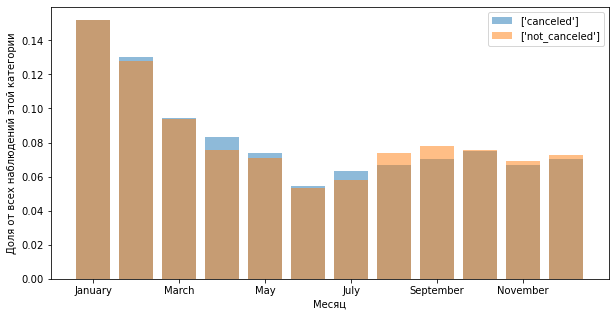

In [65]:
multiv_target_bar_normalized(data_full,'order_date_month',xlabel='Месяц', sort_index=True)
plt.show()

**'order_date_day_of_month'**

In [66]:
univ_quant_describe(data_full,'order_date_day_of_month')

,order_date_day_of_month
count,68547.000
mean,15.315
mode,2.000
var,75.788
stddev,8.706
min,1.000
25%,8.000
50%,15.000
75%,23.000
max,31.000


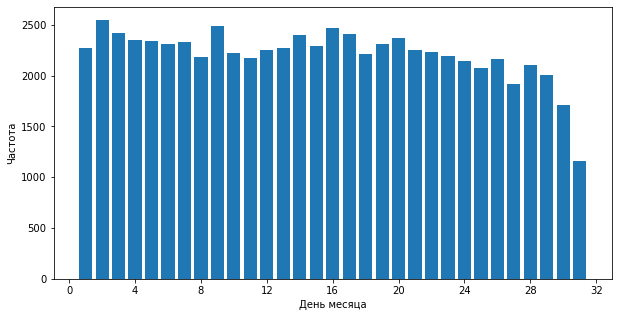

In [67]:
univ_bar(data_full,'order_date_day_of_month',xlabel='День месяца')
plt.show()

In [68]:
multi_crosstab(data_full,'order_date_day_of_month')

order_date_day_of_month,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.35%,3.69%,3.66%,3.35%,3.49%,3.30%,3.43%,3.21%,3.64%,3.32%,3.16%,3.12%,3.28%,3.61%,3.31%,3.66%,3.33%,3.18%,3.47%,3.55%,3.27%,3.25%,3.21%,3.03%,3.06%,3.12%,2.75%,3.03%,2.97%,2.52%,1.66%
1,3.22%,3.79%,3.22%,3.60%,3.22%,3.53%,3.30%,3.12%,3.62%,3.02%,3.20%,3.71%,3.40%,3.21%,3.44%,3.48%,3.99%,3.33%,3.11%,3.19%,3.33%,3.25%,3.15%,3.36%,2.94%,3.23%,2.91%,3.17%,2.78%,2.40%,1.76%
diff,-0.13%,0.11%,-0.44%,0.25%,-0.27%,0.23%,-0.13%,-0.09%,-0.01%,-0.30%,0.04%,0.59%,0.12%,-0.41%,0.13%,-0.18%,0.65%,0.15%,-0.36%,-0.36%,0.06%,0.01%,-0.06%,0.33%,-0.12%,0.11%,0.16%,0.14%,-0.19%,-0.12%,0.10%


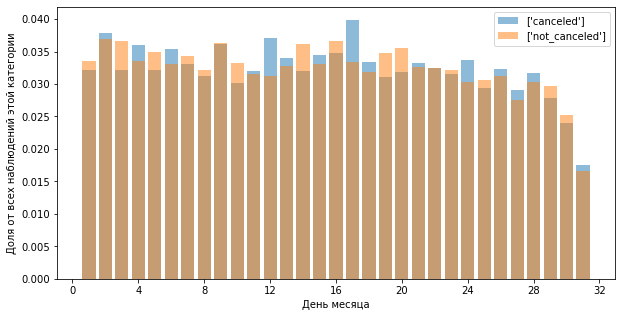

In [69]:
multiv_target_bar_normalized(data_full,'order_date_day_of_month',xlabel='День месяца')
plt.show()

In [70]:
data_full.loc[(data_full['order_date_day_of_month'] == 17) & (data_full['is_canceled'] == 1),'order_date'].value_counts()[0:3]

2014-10-17    134
2017-01-17     46
2016-05-17     42
Name: order_date, dtype: int64

In [71]:
data_full.loc[data_full['order_date']=='2014-10-17','is_canceled'].value_counts()

1    134
0     18
Name: is_canceled, dtype: int64

**'order_date_week_number'**

In [72]:
univ_cat_describe(data_full,'order_date_week_number')

,count,proportion
value,,
1,2460,0.0359
2,2288,0.0334
3,2459,0.0359
4,2311,0.0337
5,2366,0.0345
6,2366,0.0345
7,2062,0.0301
8,1973,0.0288
9,1681,0.0245


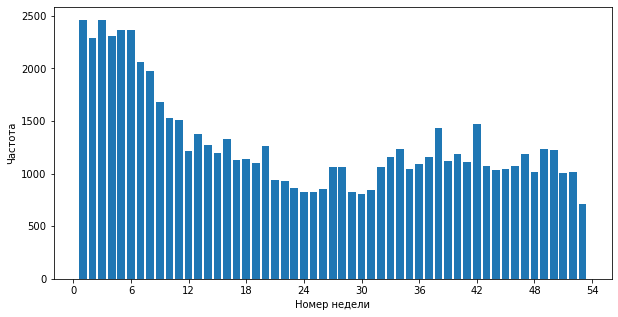

In [73]:
univ_bar(data_full,'order_date_week_number',xlabel='Номер недели')
plt.show()

In [74]:
multi_crosstab(data_full,'order_date_week_number')

order_date_week_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.53%,3.31%,3.62%,3.43%,3.51%,3.44%,2.99%,2.82%,2.48%,2.27%,2.20%,1.75%,1.91%,1.83%,1.67%,1.91%,1.61%,1.67%,1.62%,1.73%,1.34%,1.37%,1.27%,1.24%,1.17%,1.23%,1.54%,1.45%,1.17%,1.18%,1.23%,1.60%,1.74%,1.85%,1.51%,1.53%,1.78%,2.19%,1.73%,1.74%,1.67%,2.09%,1.57%,1.54%,1.52%,1.59%,1.72%,1.49%,1.91%,1.74%,1.53%,1.45%,1.04%
1,3.74%,3.40%,3.49%,3.23%,3.31%,3.48%,3.05%,3.04%,2.37%,2.13%,2.20%,1.86%,2.24%,1.94%,1.92%,2.02%,1.75%,1.62%,1.56%,2.15%,1.42%,1.30%,1.24%,1.13%,1.32%,1.28%,1.57%,1.81%,1.32%,1.19%,1.25%,1.45%,1.54%,1.64%,1.55%,1.75%,1.46%,1.82%,1.36%,1.73%,1.46%,2.27%,1.53%,1.44%,1.56%,1.51%,1.77%,1.44%,1.53%,1.92%,1.30%,1.58%,1.04%
diff,0.22%,0.09%,-0.13%,-0.20%,-0.20%,0.04%,0.06%,0.22%,-0.11%,-0.14%,0.00%,0.11%,0.34%,0.11%,0.24%,0.11%,0.14%,-0.05%,-0.06%,0.43%,0.08%,-0.06%,-0.03%,-0.11%,0.15%,0.04%,0.03%,0.37%,0.15%,0.02%,0.03%,-0.14%,-0.20%,-0.21%,0.05%,0.21%,-0.31%,-0.36%,-0.37%,-0.01%,-0.22%,0.17%,-0.04%,-0.10%,0.04%,-0.08%,0.06%,-0.05%,-0.38%,0.19%,-0.23%,0.14%,-0.01%


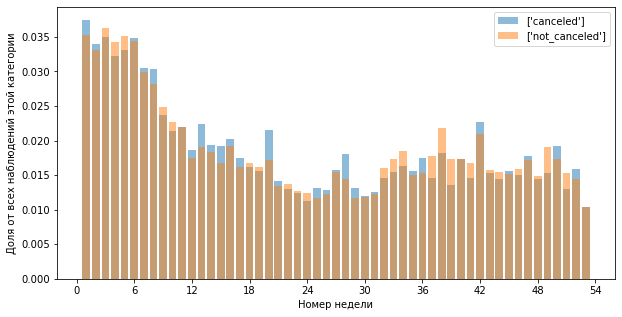

In [75]:
multiv_target_bar_normalized(data_full,'order_date_week_number',xlabel='Номер недели')
plt.show()

In [76]:
data_full.loc[(data_full['order_date_week_number'] == 42) & (data_full['is_canceled'] == 1),'order_date'].value_counts()[0:3]
# data_full.loc[data_full['order_date']=='2014-10-17','is_canceled'].value_counts()

2014-10-17    134
2016-10-17     35
2016-10-19     34
Name: order_date, dtype: int64

**Вывод**

`'arrival_date_year'`

* Кол-во наблюдений в трейне за 2015 год == 9,8к, за 2016 == 34к

`'arrival_date_month'`

* Реже отменяют бронь в январе, феврале, марте,, сентябре, октябре, ноябре.
* Чаще отменяют бронь в сезон: с апреля по август.

`'arrival_date_week_number'`

* Наблюдения за 2015 год есть только с середины до конца года и это распределение визуально отличается от распределения того же периода за 2016 год.
* По отменам брони картина повторяет месячную. Весной и летом отменяют чаще. И последняя неделя - тоже больше шанс отмены.

`'order_date_month'`

* Чаще бронируют с января по март.
* Значимых различий по шансу отмены - нет.

`'order_date_week_number'`

* Повторяет картину с месяцами ордера.
* Значимых различий по шансу отмены - нет.

#### Изучение длительности пребывания

**'stays_in_weekend_nights'**

In [77]:
univ_cat_describe(data_full,'stays_in_weekend_nights')

,count,proportion
value,,
0,28426,0.4147
1,19196,0.2800
2,20407,0.2977
3,310,0.0045
4,208,0.0030


In [78]:
univ_quant_describe(data_full,'stays_in_weekend_nights')

,stays_in_weekend_nights
count,68547.000
mean,0.901
mode,0.000
var,0.748
stddev,0.865
min,0.000
25%,0.000
50%,1.000
75%,2.000
max,4.000


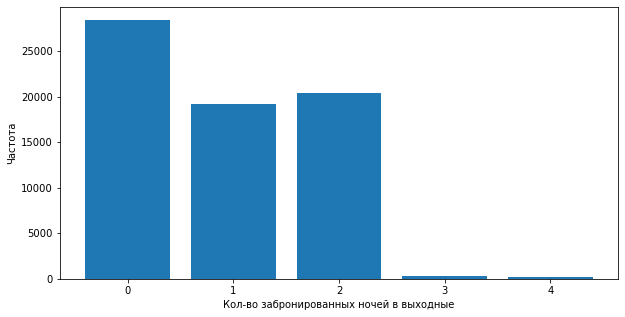

In [79]:
univ_bar(data_full,'stays_in_weekend_nights',xlabel='Кол-во забронированных ночей в выходные')
plt.show()

In [80]:
multi_crosstab(data_full,'stays_in_weekend_nights')

stays_in_weekend_nights,0,1,2,3,4
is_canceled,,,,,
0,42.53%,27.95%,28.82%,0.42%,0.28%
1,38.69%,28.14%,32.26%,0.54%,0.37%
diff,-3.83%,0.19%,3.43%,0.12%,0.09%


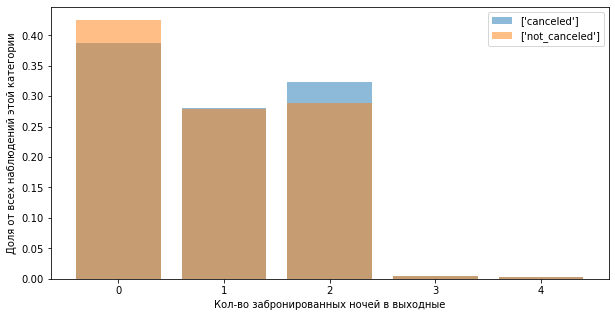

In [81]:
fig,ax = multiv_target_bar_normalized(data_full,'stays_in_weekend_nights',xlabel='Кол-во забронированных ночей в выходные')
# fig.set_size_inches(18.5, 10.5)
plt.show()

**'stays_in_week_nights'**

In [82]:
univ_cat_describe(data_full,'stays_in_week_nights')

,count,proportion
value,,
0,4638,0.0677
1,18269,0.2665
2,17541,0.2559
3,14013,0.2044
4,6480,0.0945
5,6800,0.0992
6,806,0.0118


In [83]:
univ_quant_describe(data_full,'stays_in_week_nights')

,stays_in_week_nights
count,68547.000
mean,2.336
mode,1.000
var,2.088
stddev,1.445
min,0.000
25%,1.000
50%,2.000
75%,3.000
max,6.000


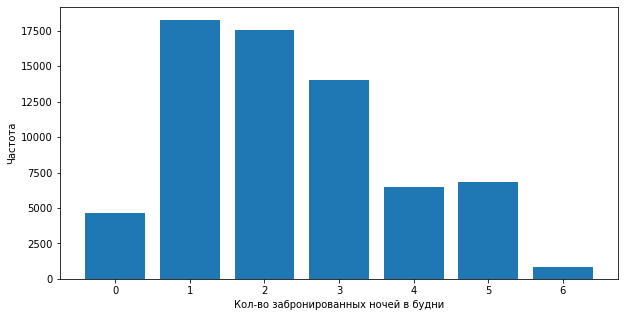

In [84]:
univ_bar(data_full,'stays_in_week_nights',xlabel='Кол-во забронированных ночей в будни')
plt.show()

In [85]:
multi_crosstab(data_full,'stays_in_week_nights')

stays_in_week_nights,0,1,2,3,4,5,6
is_canceled,,,,,,,
0,7.39%,28.46%,25.04%,19.76%,8.85%,9.47%,1.05%
1,5.14%,21.92%,27.04%,22.24%,11.04%,11.11%,1.49%
diff,-2.24%,-6.53%,2.01%,2.48%,2.20%,1.65%,0.44%


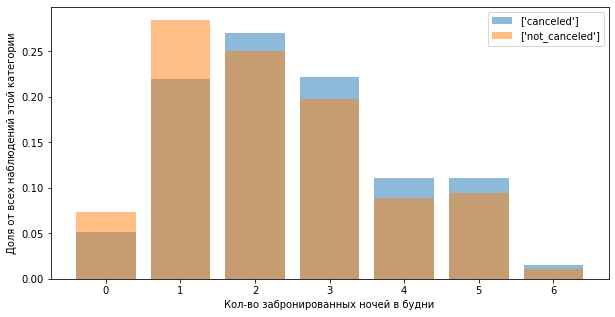

In [86]:
multiv_target_bar_normalized(data_full,'stays_in_week_nights',xlabel='Кол-во забронированных ночей в будни')
plt.show()

**'total_nights'**

In [87]:
univ_cat_describe(data_full,'total_nights')

,count,proportion
value,,
1,13883,0.2025
2,12985,0.1894
3,15510,0.2263
4,11784,0.1719
5,5677,0.0828
6,2474,0.0361
7,5209,0.0760
8,680,0.0099
9,183,0.0027


In [88]:
univ_quant_describe(data_full,'total_nights')

,total_nights
count,68547.000
mean,3.237
mode,3.000
var,3.447
stddev,1.857
min,1.000
25%,2.000
50%,3.000
75%,4.000
max,10.000


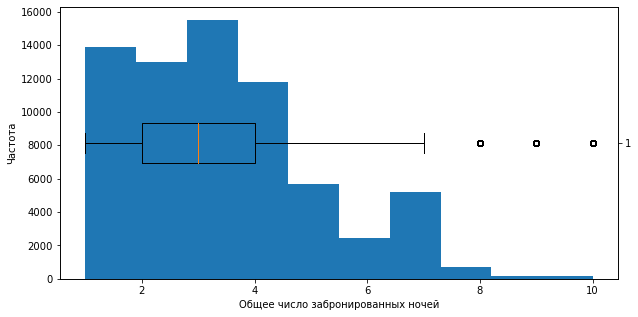

In [89]:
univ_hist_box(data_full,'total_nights',xlabel='Общее число забронированных ночей')
plt.show()

In [90]:
multi_crosstab(data_full,'total_nights')

total_nights,1,2,3,4,5,6,7,8,9,10
is_canceled,,,,,,,,,,
0,22.73%,18.96%,21.82%,16.46%,8.05%,3.30%,7.34%,0.88%,0.25%,0.21%
1,13.76%,18.90%,24.75%,19.11%,8.89%,4.43%,8.29%,1.27%,0.31%,0.30%
diff,-8.97%,-0.06%,2.93%,2.65%,0.84%,1.14%,0.95%,0.39%,0.05%,0.08%


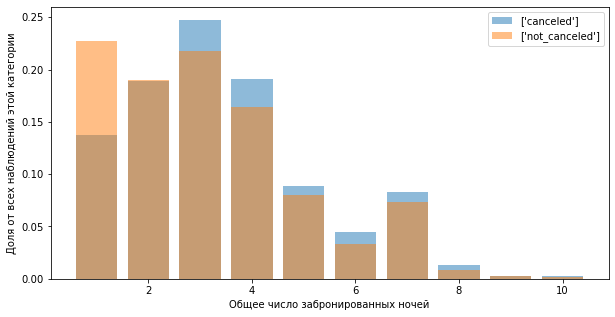

In [91]:
multiv_target_bar_normalized(data_full,'total_nights',xlabel='Общее число забронированных ночей')
plt.show()

**Вывод**

`'stays_in_weekend_nights'`

* Выбросов нет.
* Редко кто бронирует на 3 и 4 выходных ночей (0.5%,0.4%)
* Разница:
	* 0 ночь в выходнеы ~4% меньше шанс отмены 
	* 2 ночи ~3% выше шанс

`'stays_in_week_nights'`

* Выбросов нет.
* Разница: 
	* 0 ночей в будни (значит бронировалось только в выходные) на ~2% ниже шанс отмены брони
	* 1 ночь в будни - ~6% ниже шанс отмены
	* от 2х до 5 ночей в будни - ~2% выше шанс отмены
    
`'total_nights'`

* Выбросы (>7 дней) 1025 (1,5%)
* Разница:
	* 1 ночь ~9% меньше шанс отмены 
	* 3 ночи ~3% выше шанс
	* 4 ночи ~3% выше шанс

#### Изучение состава и кол-ва постояльцев

**'adults'**

In [92]:
univ_cat_describe(data_full,'adults')

,count,proportion
value,,
0.0000,229,0.0033
1.0000,13066,0.1906
2.0000,50835,0.7416
3.0000,4396,0.0641
4.0000,21,0.0003


In [93]:
univ_quant_describe(data_full,'adults')

,adults
count,68547.000
mean,1.867
mode,2.000
var,0.252
stddev,0.502
min,0.000
25%,2.000
50%,2.000
75%,2.000
max,4.000


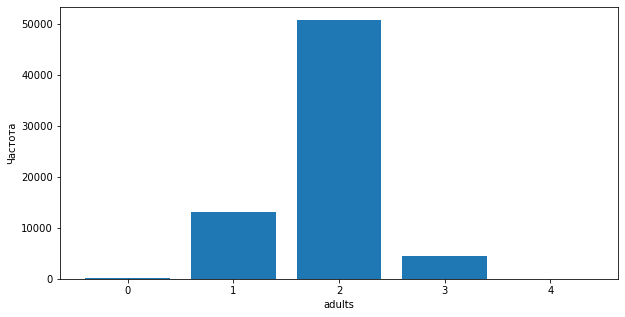

In [94]:
univ_bar(data_full,'adults')
plt.show()

In [95]:
multi_crosstab(data_full,'adults')

adults,0.0,1.0,2.0,3.0,4.0
is_canceled,,,,,
0,0.31%,21.17%,72.60%,5.89%,0.03%
1,0.40%,13.53%,78.25%,7.80%,0.03%
diff,0.09%,-7.65%,5.65%,1.91%,-0.01%


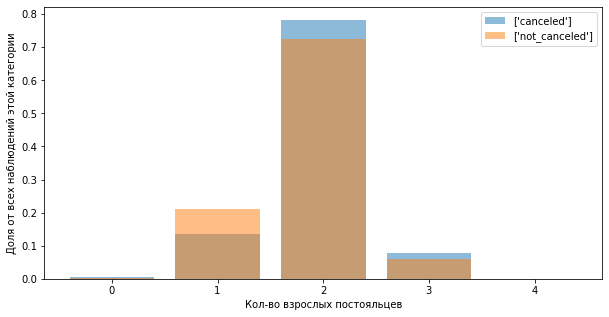

In [96]:
multiv_target_bar_normalized(data_full,'adults',xlabel='Кол-во взрослых постояльцев')
plt.show()

**'children'**

In [97]:
univ_cat_describe(data_full,'children')

,count,proportion
value,,
0.0000,63198,0.9220
1.0000,3382,0.0493
2.0000,1946,0.0284
3.0000,21,0.0003


In [98]:
univ_quant_describe(data_full,'children')

,children
count,68547.000
mean,0.107
mode,0.000
var,0.154
stddev,0.393
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,3.000


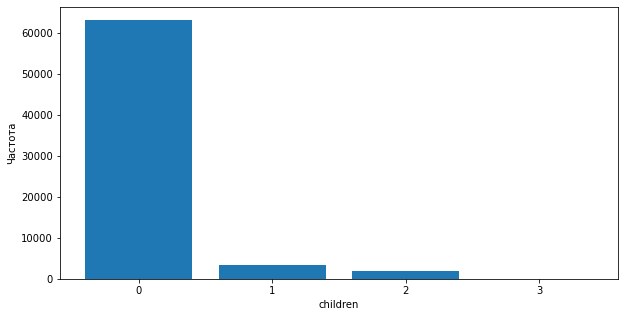

In [99]:
univ_bar(data_full,'children')
plt.show()

In [100]:
multi_crosstab(data_full,'children')

children,0.0,1.0,2.0,3.0
is_canceled,,,,
0,92.84%,4.76%,2.37%,0.03%
1,90.52%,5.39%,4.06%,0.04%
diff,-2.32%,0.63%,1.68%,0.01%


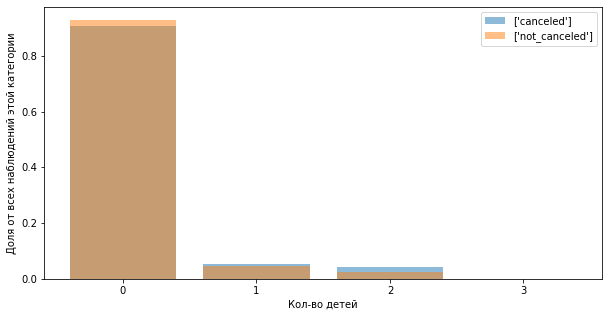

In [101]:
multiv_target_bar_normalized(data_full,'children',xlabel='Кол-во детей')
plt.show()

**'babies'**

In [102]:
univ_cat_describe(data_full,'babies')

,count,proportion
value,,
0.0000,67924,0.9909
1.0000,614,0.0090
2.0000,7,0.0001
9.0000,1,0.0000
10.0000,1,0.0000


In [103]:
univ_quant_describe(data_full,'babies')

,babies
count,68547.000
mean,0.009
mode,0.000
var,0.012
stddev,0.109
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,10.000


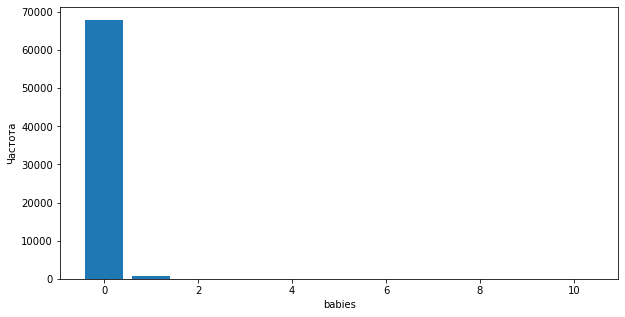

In [104]:
univ_bar(data_full,'babies')
plt.show()

In [105]:
multi_crosstab(data_full,'babies')

babies,0.0,1.0,2.0,9.0,10.0
is_canceled,,,,,
0,98.95%,1.03%,0.01%,0.00%,0.00%
1,99.45%,0.55%,0.00%,0.00%,0.00%
diff,0.50%,-0.48%,-0.01%,-0.00%,-0.00%


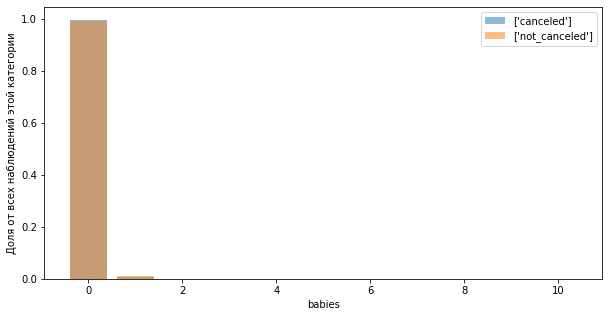

In [106]:
multiv_target_bar_normalized(data_full,'babies')
plt.show()

**Вывод**

`'adults'`

* Выбросы (>2) 17712 (20%)
* Можно ли сдавать номера исключительно детям? В некоторых наблюдениях 'adults'==0
* Разница:
	* 1 взрослый - ~8% ниже шанс отмены брони
	* 2 взрослых - ~6% выше шанс отмены брони

`'children'`

* Выбросы (>0) 5349 (7%)
* Чаще без детей. (92%)
* По отменам существенной разницы нет.

`'babies'`

* Выбросы (>0) 623 (0.9%)
* Чаще без младенцев. (99%)
* По отменам существенной разницы нет.
* Есть подозрительные значения 9 и 10. <- можно убрать

#### 'meal'


In [107]:
univ_cat_describe(data_full,'meal')

,count,proportion
value,,
HB,5203,0.0759
FB,165,0.0024
SC,9314,0.1359
BB,53865,0.7858


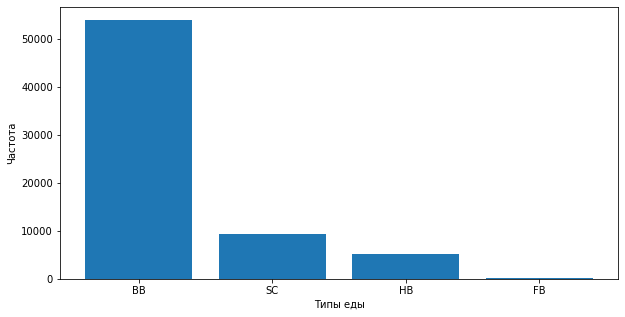

In [108]:
univ_bar(data_full,'meal',xlabel='Типы еды')
plt.show()

In [109]:
multi_crosstab(data_full,'meal')

meal,BB,FB,HB,SC
is_canceled,,,,
0,79.89%,0.23%,7.65%,12.22%
1,75.14%,0.26%,7.44%,17.16%
diff,-4.76%,0.03%,-0.21%,4.94%


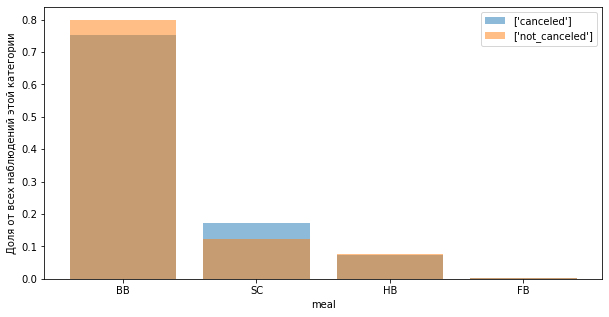

In [110]:
multiv_target_bar_normalized(data_full,'meal',sort=True)
plt.show()

**Вывод**
* BB - на ~5% ниже шанс отмены.
* SC - на ~5% выше шанс отмены

#### 'country'

In [111]:
data_full['country'].describe()

count     68547
unique      174
top         PRT
freq      19903
Name: country, dtype: object

In [112]:
univ_cat_describe(data_full,'country',sort=True).query('count > 1000')

,count,proportion
value,,
PRT,19903,0.2904
FRA,7813,0.1140
GBR,7621,0.1112
ESP,5537,0.0808
DEU,4726,0.0689
ITA,2721,0.0397
IRL,2168,0.0316
BEL,1862,0.0272
BRA,1725,0.0252


In [113]:
univ_cat_describe(data_full,'country',sort=True).query('count <= 1000').count()

count         162
proportion    162
dtype: int64

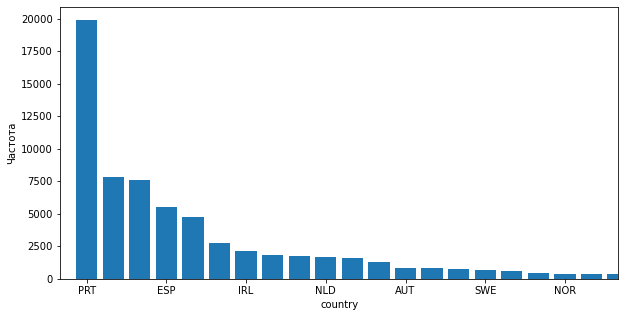

In [114]:
fig,ax = univ_bar(data_full,'country')
ax.set_xlim(-1,20)
plt.show()

In [115]:
multi_crosstab(data_full,'country')

country,ABW,AGO,ALB,AND,ARE,ARG,ARM,ASM,ATA,ATF,AUS,AUT,AZE,BDI,BEL,BEN,BFA,BGD,BGR,BHR,BHS,BIH,BLR,BOL,BRA,BRB,BWA,CAF,CHE,CHL,CHN,CIV,CMR,CN,COL,CPV,CRI,CUB,CYM,CYP,CZE,DEU,DMA,DNK,DOM,DZA,ECU,EGY,ESP,EST,ETH,FIN,FJI,FRA,FRO,GAB,GBR,GEO,GGY,GHA,GIB,GLP,GNB,GRC,GTM,GUY,HKG,HND,HRV,HUN,IDN,IMN,IND,IRL,IRN,IRQ,ISL,ISR,ITA,JAM,JEY,JOR,JPN,KAZ,KEN,KHM,KIR,KNA,KOR,KWT,LAO,LBN,LBY,LCA,LIE,LKA,LTU,LUX,LVA,MAC,MAR,MCO,MDG,MDV,MEX,MKD,MLI,MLT,MMR,MNE,MOZ,MRT,MUS,MWI,MYS,MYT,NAM,NCL,NGA,NIC,NLD,NOR,NPL,NZL,OMN,PAK,PAN,PER,PHL,PLW,POL,PRI,PRT,PRY,PYF,QAT,ROU,RUS,RWA,SAU,SDN,SEN,SGP,SLE,SLV,SMR,SRB,STP,SUR,SVK,SVN,SWE,SYC,SYR,TGO,THA,TJK,TMP,TUN,TUR,TWN,TZA,UGA,UKR,UMI,URY,USA,UZB,VEN,VGB,VNM,ZAF,ZMB,ZWE
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.00%,0.23%,0.02%,0.00%,0.01%,0.26%,0.01%,0.00%,0.00%,0.00%,0.44%,1.37%,0.01%,0.00%,3.02%,0.00%,0.00%,0.00%,0.11%,0.00%,0.00%,0.02%,0.03%,0.00%,2.18%,0.00%,0.00%,0.01%,2.04%,0.08%,0.76%,0.00%,0.02%,1.28%,0.08%,0.02%,0.03%,0.01%,0.00%,0.06%,0.18%,7.60%,0.00%,0.50%,0.01%,0.10%,0.03%,0.04%,8.32%,0.10%,0.00%,0.60%,0.00%,12.66%,0.00%,0.00%,12.15%,0.01%,0.00%,0.00%,0.01%,0.00%,0.01%,0.16%,0.00%,0.00%,0.00%,0.00%,0.13%,0.23%,0.02%,0.00%,0.19%,3.35%,0.11%,0.02%,0.03%,0.47%,3.49%,0.01%,0.00%,0.03%,0.29%,0.03%,0.01%,0.00%,0.00%,0.00%,0.15%,0.02%,0.00%,0.04%,0.01%,0.00%,0.00%,0.01%,0.10%,0.25%,0.07%,0.00%,0.19%,0.01%,0.00%,0.00%,0.11%,0.01%,0.00%,0.02%,0.00%,0.01%,0.07%,0.00%,0.01%,0.00%,0.04%,0.00%,0.00%,0.00%,0.02%,0.00%,2.73%,0.59%,0.00%,0.09%,0.01%,0.01%,0.01%,0.03%,0.02%,0.00%,1.00%,0.01%,25.80%,0.01%,0.00%,0.01%,0.55%,0.55%,0.00%,0.02%,0.00%,0.01%,0.04%,0.00%,0.00%,0.00%,0.08%,0.00%,0.01%,0.07%,0.06%,1.05%,0.00%,0.01%,0.00%,0.04%,0.00%,0.00%,0.04%,0.21%,0.06%,0.00%,0.00%,0.07%,0.00%,0.04%,2.37%,0.00%,0.03%,0.00%,0.01%,0.09%,0.00%,0.00%
1,0.00%,0.38%,0.01%,0.01%,0.16%,0.23%,0.01%,0.00%,0.00%,0.00%,0.43%,0.79%,0.04%,0.00%,1.92%,0.02%,0.00%,0.03%,0.04%,0.02%,0.00%,0.02%,0.03%,0.00%,3.39%,0.00%,0.00%,0.00%,1.60%,0.07%,1.89%,0.01%,0.00%,0.95%,0.12%,0.05%,0.01%,0.00%,0.00%,0.04%,0.16%,5.04%,0.00%,0.42%,0.03%,0.07%,0.02%,0.04%,7.44%,0.07%,0.01%,0.31%,0.01%,8.08%,0.00%,0.01%,8.42%,0.04%,0.01%,0.00%,0.04%,0.01%,0.01%,0.16%,0.00%,0.00%,0.11%,0.01%,0.12%,0.31%,0.06%,0.01%,0.15%,2.67%,0.10%,0.00%,0.02%,0.65%,5.22%,0.00%,0.03%,0.02%,0.12%,0.02%,0.01%,0.01%,0.00%,0.00%,0.22%,0.02%,0.00%,0.03%,0.00%,0.00%,0.01%,0.00%,0.03%,0.45%,0.03%,0.05%,0.36%,0.01%,0.00%,0.04%,0.04%,0.01%,0.00%,0.03%,0.00%,0.01%,0.06%,0.00%,0.01%,0.00%,0.02%,0.01%,0.00%,0.00%,0.08%,0.01%,1.67%,0.59%,0.00%,0.02%,0.02%,0.03%,0.00%,0.03%,0.08%,0.00%,0.67%,0.01%,37.53%,0.00%,0.00%,0.04%,0.52%,0.90%,0.00%,0.09%,0.00%,0.01%,0.06%,0.00%,0.00%,0.00%,0.02%,0.00%,0.00%,0.04%,0.04%,0.77%,0.01%,0.00%,0.00%,0.05%,0.01%,0.01%,0.09%,0.49%,0.06%,0.02%,0.00%,0.09%,0.01%,0.03%,2.05%,0.01%,0.04%,0.01%,0.01%,0.13%,0.01%,0.01%
diff,-0.00%,0.14%,-0.01%,0.01%,0.16%,-0.04%,0.00%,-0.00%,-0.00%,-0.00%,-0.01%,-0.58%,0.02%,-0.00%,-1.10%,0.02%,-0.00%,0.03%,-0.07%,0.01%,-0.00%,-0.00%,-0.00%,-0.00%,1.21%,-0.00%,-0.00%,-0.01%,-0.45%,-0.00%,1.12%,0.00%,-0.02%,-0.33%,0.03%,0.03%,-0.03%,-0.01%,-0.00%,-0.03%,-0.02%,-2.56%,-0.00%,-0.08%,0.02%,-0.03%,-0.01%,0.00%,-0.88%,-0.02%,0.00%,-0.29%,0.01%,-4.58%,-0.00%,0.01%,-3.72%,0.03%,0.01%,-0.00%,0.03%,0.01%,-0.00%,0.01%,-0.00%,-0.00%,0.10%,0.01%,-0.01%,0.08%,0.04%,0.01%,-0.03%,-0.68%,-0.01%,-0.02%,-0.01%,0.18%,1.73%,-0.01%,0.03%,-0.01%,-0.17%,-0.01%,0.00%,0.01%,-0.00%,-0.00%,0.07%,0.00%,-0.00%,-0.01%,-0.01%,-0.00%,0.00%,-0.01%,-0.07%,0.20%,-0.04%,0.05%,0.17%,-0.00%,-0.00%,0.03%,-0.07%,0.00%,-0.00%,0.00%,-0.00%,0.00%,-0.01%,-0.00%,-0.01%,-0.00%,-0.02%,0.01%,-0.00%,-0.00%,0.06%,0.01%,-1.06%,-0.00%,-0.00%,-0.07%,0.00%,0.02%,-0.01%,-0.00%,0.06%,-0.00%,-0.33%,-0.01%,11.73%,-0.01%,-0.00%,0.03%,-0.02%,0.35%,-0.00%,0.07%,-0.00%,0.00%,0.01%,-0.00%,-0.00%,-0.00%,-0.07%,-0.00%,-0.01%,-0.04%,-0.02%,-0.28%,

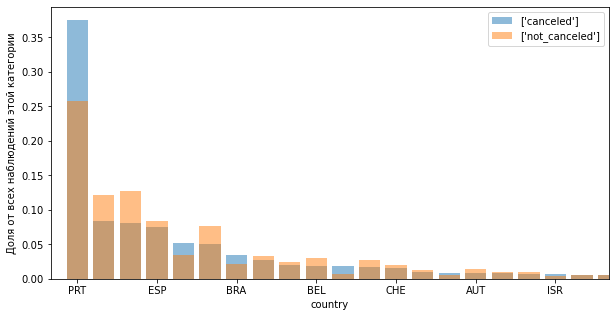

In [116]:
fig,ax = multiv_target_bar_normalized(data_full,'country',sort=True)
ax.set_xlim(-1,20)
plt.show()

**Вывод**
* 174 уникальных значения
* 13 стран имеют наблюдений больше 1000
* Клиенты из Португалии имеют на ~11% больше вероятность отменить бронь.

#### 'distribution_channel'

In [117]:
univ_cat_describe(data_full,'distribution_channel')

,count,proportion
value,,
Corporate,3969,0.0579
GDS,169,0.0025
Direct,9006,0.1314
TA/TO,55403,0.8082


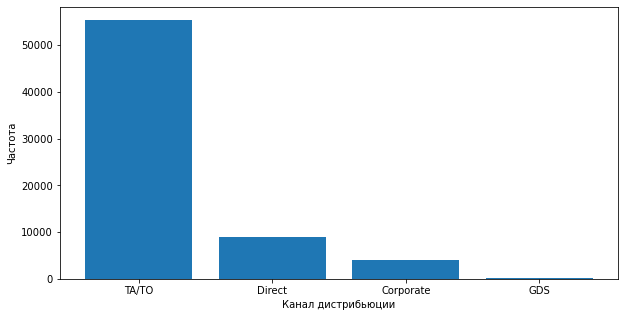

In [118]:
univ_bar(data_full,'distribution_channel',xlabel='Канал дистрибьюции')
plt.show()

In [119]:
multi_crosstab(data_full,'distribution_channel')

distribution_channel,Corporate,Direct,GDS,TA/TO
is_canceled,,,,
0,6.97%,15.58%,0.28%,77.17%
1,2.70%,6.74%,0.16%,90.40%
diff,-4.27%,-8.83%,-0.12%,13.23%


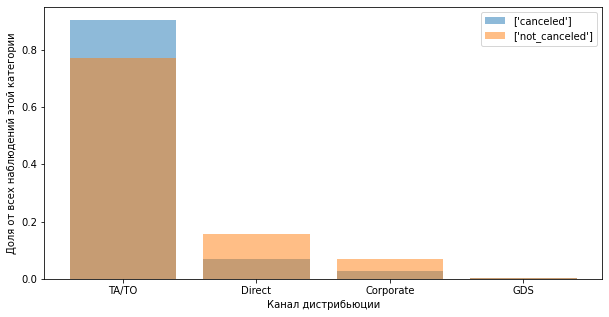

In [120]:
multiv_target_bar_normalized(data_full,'distribution_channel',xlabel='Канал дистрибьюции',sort=True)
plt.show()

**Вывод**
* 80% - приходится на TA/TO
* Разница:
	* TA/TO - на ~13% выше шанс отмены
	* Direct - на ~9% ниже шанс
	* Corporate - на ~4% ниже шанс

#### 'is_repeated_guest'

In [121]:
univ_cat_describe(data_full,'is_repeated_guest')

,count,proportion
value,,
0,66102,0.9643
1,2445,0.0357


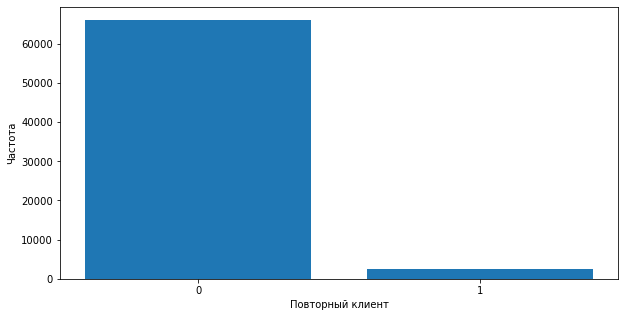

In [122]:
univ_bar(data_full,'is_repeated_guest',xlabel='Повторный клиент')
plt.show()

In [123]:
multi_crosstab(data_full,'is_repeated_guest')

is_repeated_guest,0,1
is_canceled,,
0,95.51%,4.49%
1,98.84%,1.16%
diff,3.33%,-3.33%


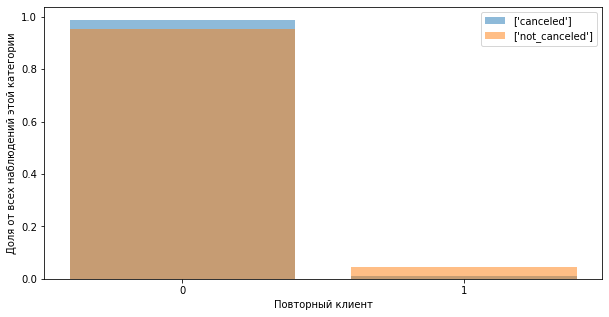

In [124]:
multiv_target_bar_normalized(data_full,'is_repeated_guest',xlabel='Повторный клиент')
plt.show()

**Вывод**
* Можно сказать, что повторный клиент с меньшим на ~3% шансом отменит бронь.

#### Изучение истории отмен/не-отмен


**'previous_cancellations'**

In [125]:
univ_cat_describe(data_full,'previous_cancellations')

,count,proportion
value,,
0,67173,0.9800
1,1157,0.0169
2,81,0.0012
3,53,0.0008
4,15,0.0002
5,14,0.0002
6,17,0.0002
11,27,0.0004
13,3,0.0000


In [126]:
univ_quant_describe(data_full,'previous_cancellations')

,previous_cancellations
count,68547.000
mean,0.032
mode,0.000
var,0.150
stddev,0.388
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,26.000


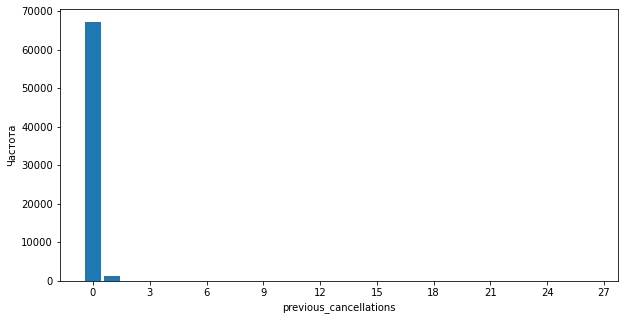

In [127]:
univ_bar(data_full,'previous_cancellations')
plt.show()

In [128]:
# multi_crosstab(data_full,'previous_cancellations',normalize='index')

In [129]:
multi_crosstab(data_full,'previous_cancellations')

previous_cancellations,0,1,2,3,4,5,6,11,13,14,19,21,24,25,26
is_canceled,,,,,,,,,,,,,,,
0,99.13%,0.55%,0.11%,0.08%,0.02%,0.02%,0.03%,0.05%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
1,95.02%,4.67%,0.13%,0.07%,0.02%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%
diff,-4.10%,4.12%,0.02%,-0.00%,-0.00%,-0.01%,-0.02%,-0.04%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%


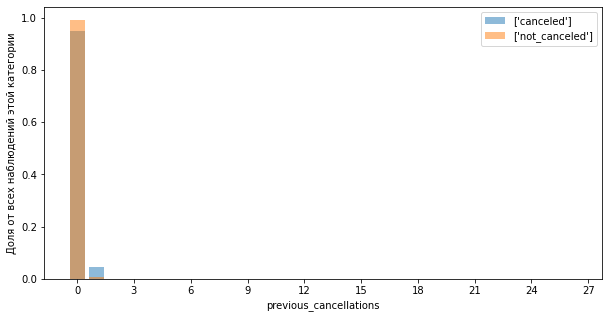

In [130]:
multiv_target_bar_normalized(data_full,'previous_cancellations')
plt.show()

**'previous_bookings_not_canceled'**

In [131]:
univ_cat_describe(data_full,'previous_bookings_not_canceled').query('count > 10')

,count,proportion
value,,
0,66033,0.9633
1,1005,0.0147
2,411,0.0060
3,221,0.0032
4,172,0.0025
5,135,0.0020
6,93,0.0014
7,67,0.0010
8,49,0.0007


In [132]:
univ_quant_describe(data_full,'previous_bookings_not_canceled')

,previous_bookings_not_canceled
count,68547.000
mean,0.180
mode,0.000
var,3.262
stddev,1.806
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,72.000


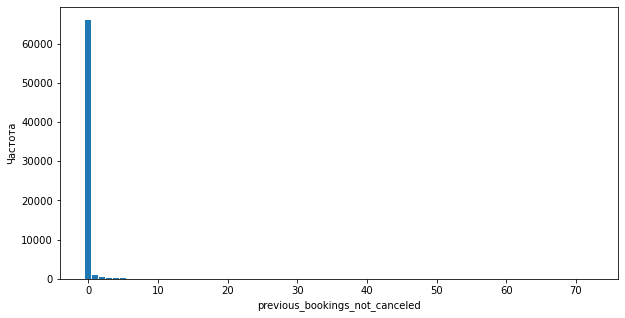

In [133]:
univ_bar(data_full,'previous_bookings_not_canceled')
plt.show()

In [134]:
multi_crosstab(data_full,'previous_bookings_not_canceled')

previous_bookings_not_canceled,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,95.19%,1.93%,0.78%,0.42%,0.33%,0.26%,0.18%,0.13%,0.09%,0.08%,0.08%,0.06%,0.05%,0.04%,0.04%,0.03%,0.03%,0.02%,0.02%,0.02%,0.01%,0.02%,0.02%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
1,99.31%,0.25%,0.13%,0.06%,0.05%,0.04%,0.01%,0.02%,0.01%,0.00%,0.02%,0.02%,0.02%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.01%,0.01%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
diff,4.12%,-1.68%,-0.65%,-0.37%,-0.28%,-0.21%,-0.17%,-0.11%,-0.08%,-0.08%,-0.06%,-0.04%,-0.04%,-0.03%,-0.03%,-0.02%,-0.02%,-0.02%,-0.02%,-0.02%,-0.01%,-0.02%,-0.02%,-0.01%,-0.01%,-0.01%,-0.00%,-0.01%,-0.01%,-0.00%,-0.01%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,0.00%,-0.00%,-0.00%,0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%


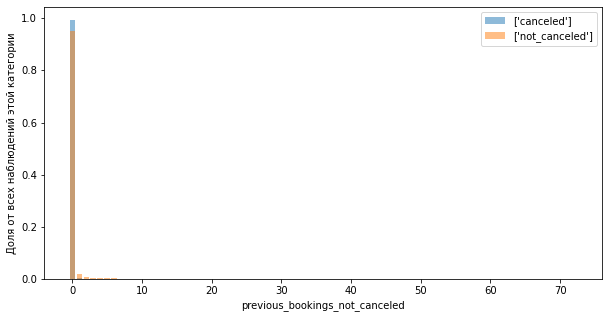

In [135]:
multiv_target_bar_normalized(data_full,'previous_bookings_not_canceled')
plt.show()

**Вывод**

`'previous_cancellations'`  

* Выбросы (>0) 1374 (2%)
* Здесь 98% всех наблюдений приходится на 0. При этом более 99% не-отмен приходится именно на 0. Стоит проверить модель с этим признаком и без него.

`'previous_bookings_not_canceled'`  

* Выбросы (>0) 2514 (4%)
* Здесь подобная ситуация (96% приходится на 0), но разница между подгруппами по таргету менее выражена. (Не более 4.12%)



#### 'reserved_room_type'

In [136]:
univ_cat_describe(data_full,'reserved_room_type').sort_index()

,count,proportion
value,,
A,47087,0.6869
B,922,0.0135
C,421,0.0061
D,13855,0.2021
E,3744,0.0546
F,1666,0.0243
G,852,0.0124


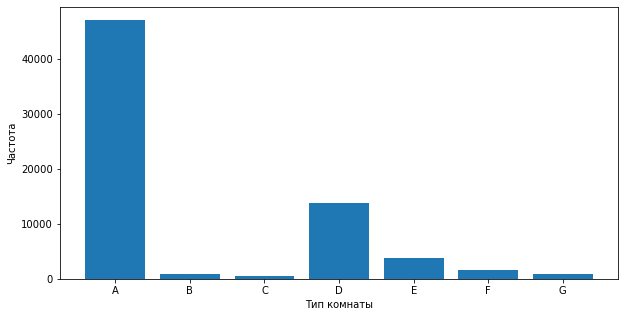

In [137]:
univ_bar(data_full,'reserved_room_type',sort_index=True,xlabel='Тип комнаты')
plt.show()

In [138]:
multi_crosstab(data_full,'reserved_room_type')

reserved_room_type,A,B,C,D,E,F,G
is_canceled,,,,,,,
0,69.72%,1.27%,0.59%,19.38%,5.56%,2.36%,1.13%
1,66.00%,1.55%,0.67%,22.41%,5.21%,2.62%,1.54%
diff,-3.72%,0.29%,0.07%,3.03%,-0.34%,0.26%,0.41%


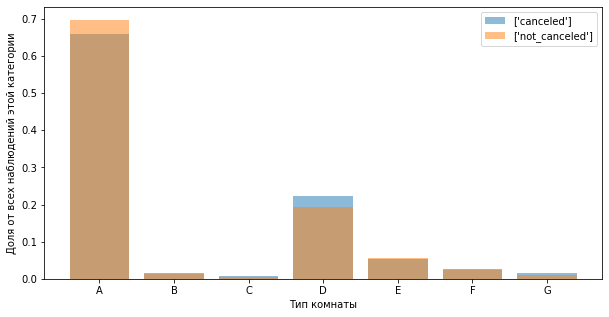

In [139]:
multiv_target_bar_normalized(data_full,'reserved_room_type',xlabel='Тип комнаты',sort_index=True)
plt.show()

**Вывод**
* Разница: 
	* А - На ~4% выше шанс отмены
	* D - На ~3% ниже шанс отмены

#### 'booking_changes'

In [140]:
univ_cat_describe(data_full,'booking_changes')

,count,proportion
value,,
0,56879,0.8298
1,7987,0.1165
2,2647,0.0386
3,632,0.0092
4,247,0.0036
5,68,0.0010
6,33,0.0005
7,23,0.0003
8,8,0.0001


In [141]:
univ_quant_describe(data_full,'booking_changes')

,booking_changes
count,68547.000
mean,0.251
mode,0.000
var,0.471
stddev,0.687
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,18.000


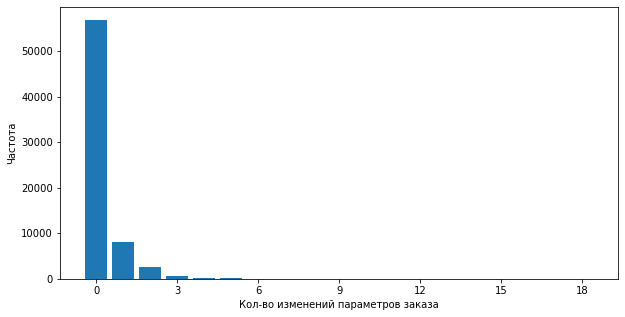

In [142]:
univ_bar(data_full,'booking_changes',xlabel='Кол-во изменений параметров заказа')
plt.show()

In [143]:
multi_crosstab(data_full,'booking_changes')

booking_changes,0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18
is_canceled,,,,,,,,,,,,,,,,,,
0,80.15%,13.96%,4.19%,1.07%,0.40%,0.11%,0.04%,0.04%,0.01%,0.01%,0.00%,0.00%,0.01%,0.00%,0.01%,0.00%,0.00%,0.00%
1,90.40%,5.61%,2.99%,0.54%,0.26%,0.08%,0.07%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.01%,0.00%,0.01%,0.00%,0.00%
diff,10.25%,-8.34%,-1.20%,-0.53%,-0.13%,-0.03%,0.04%,-0.03%,-0.00%,-0.00%,0.00%,-0.00%,-0.01%,0.00%,-0.01%,0.00%,-0.00%,-0.00%


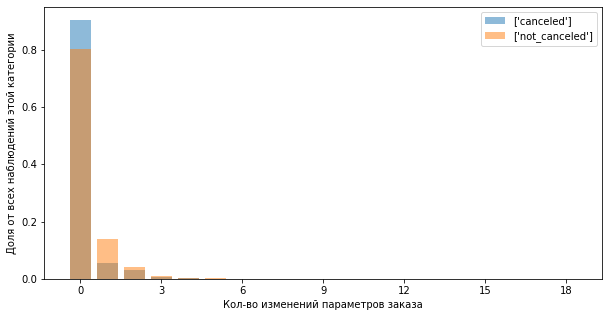

In [144]:
multiv_target_bar_normalized(data_full,'booking_changes',xlabel='Кол-во изменений параметров заказа')
plt.show()

**Вывод**
* Выбросы (>0) 11668 (17%)
* Разница:
	* Количество изменений параметров заказа 0 - на 10% выше шанс отмены
	* 1 - на ~8% ниже шанс

#### 'days_in_waiting_list'

In [145]:
univ_cat_describe(data_full,'days_in_waiting_list',sort=True).head()

,count,proportion
value,,
0,67892,0.9904
63,45,0.0007
15,21,0.0003
44,18,0.0003
87,18,0.0003


In [146]:
univ_quant_describe(data_full,'days_in_waiting_list')

,days_in_waiting_list
count,68547.000
mean,0.648
mode,0.000
var,73.304
stddev,8.562
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,259.000


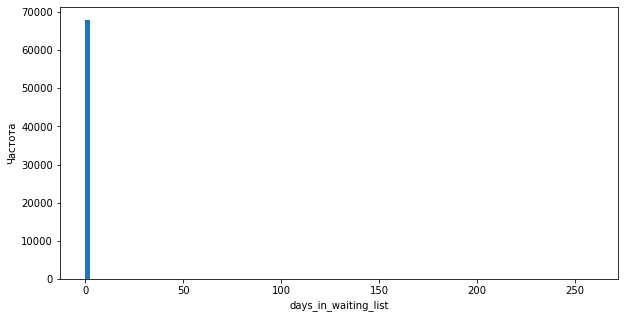

In [147]:
univ_hist(data_full,'days_in_waiting_list')
plt.show()

In [148]:
multi_crosstab(data_full,'days_in_waiting_list')

days_in_waiting_list,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,47,48,49,50,53,54,55,56,57,58,59,60,61,62,63,64,65,68,69,70,71,72,73,74,75,76,77,79,80,81,83,84,85,87,89,91,93,96,98,99,100,101,105,107,108,109,111,113,117,120,121,122,125,142,147,150,154,160,162,165,167,174,175,176,178,183,185,187,193,207,215,223,224,236,259
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,99.20%,0.01%,0.01%,0.00%,0.03%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.01%,0.03%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.01%,0.00%,0.02%,0.00%,0.00%,0.00%,0.00%,0.01%,0.02%,0.00%,0.00%,0.02%,0.00%,0.01%,0.00%,0.00%,0.02%,0.02%,0.00%,0.00%,0.01%,0.03%,0.01%,0.01%,0.01%,0.00%,0.00%,0.01%,0.00%,0.02%,0.01%,0.01%,0.01%,0.00%,0.08%,0.00%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.00%,0.02%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.03%,0.00%,0.00%,0.00%,0.01%,0.01%,0.01%,0.00%,0.01%,0.00%,0.00%,0.01%,0.00%,0.01%,0.01%,0.00%,0.00%,0.00%,0.01%,0.01%,0.00%,0.01%,0.01%,0.00%,0.00%,0.01%,0.00%,0.00%,0.01%,0.00%,0.02%,0.01%,0.00%,0.00%,0.02%,0.00%,0.01%,0.00%,0.00%,0.01%,0.01%,0.01%
1,98.64%,0.01%,0.01%,0.01%,0.01%,0.02%,0.00%,0.02%,0.02%,0.02%,0.02%,0.02%,0.01%,0.01%,0.02%,0.02%,0.02%,0.03%,0.01%,0.01%,0.03%,0.02%,0.02%,0.01%,0.01%,0.01%,0.02%,0.02%,0.03%,0.01%,0.05%,0.02%,0.01%,0.03%,0.03%,0.00%,0.02%,0.04%,0.02%,0.03%,0.01%,0.01%,0.04%,0.01%,0.04%,0.01%,0.01%,0.01%,0.02%,0.01%,0.01%,0.01%,0.02%,0.02%,0.00%,0.03%,0.03%,0.01%,0.01%,0.03%,0.00%,0.00%,0.01%,0.03%,0.01%,0.04%,0.00%,0.01%,0.00%,0.01%,0.01%,0.01%,0.01%,0.02%,0.00%,0.00%,0.01%,0.01%,0.01%,0.00%,0.01%,0.02%,0.02%,0.02%,0.01%,0.01%,0.02%,0.00%,0.02%,0.01%,0.00%,0.02%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.01%,0.01%,0.01%,0.00%,0.01%,0.01%,0.01%,0.01%,0.01%,0.00%,0.01%,0.01%,0.01%,0.01%,0.00%,0.01%,0.01%,0.00%
diff,-0.56%,-0.00%,-0.00%,0.01%,-0.02%,0.02%,-0.01%,0.01%,0.02%,0.01%,0.01%,0.01%,0.00%,-0.00%,0.01%,-0.01%,0.02%,0.03%,0.01%,0.01%,0.02%,0.02%,0.01%,0.01%,0.01%,-0.00%,0.02%,-0.00%,0.03%,0.01%,0.05%,0.02%,-0.00%,0.01%,0.02%,-0.00%,-0.00%,0.04%,0.01%,0.03%,0.01%,-0.01%,0.02%,0.01%,0.03%,-0.00%,-0.02%,-0.01%,0.01%,-0.00%,0.01%,0.01%,0.01%,0.02%,-0.02%,0.01%,0.03%,-0.01%,0.01%,-0.05%,-0.00%,-0.01%,0.00%,0.02%,0.01%,0.04%,-0.00%,0.01%,-0.00%,-0.00%,0.01%,-0.01%,0.01%,0.01%,-0.00%,-0.00%,0.00%,0.01%,-0.03%,-0.00%,0.01%,0.01%,0.01%,0.01%,-0.00%,0.01%,0.02%,-0.00%,0.01%,-0.01%,-0.00%,0.01%,-0.00%,0.01%,0.01%,0.01%,-0.01%,-0.01%,-0.00%,-0.00%,-0.01%,-0.00%,0.01%,0.00%,0.01%,-0.00%,-0.00%,0.01%,-0.01%,-0.01%,0.01%,-0.00%,-0.01%,0.01%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,-0.01%


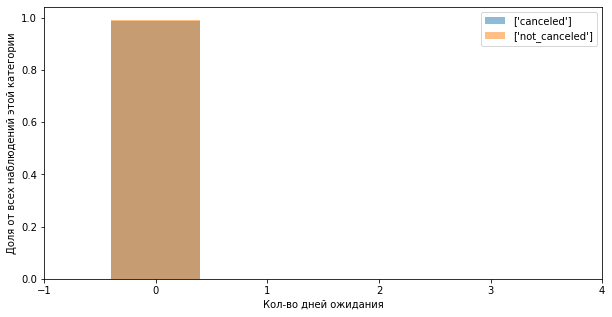

In [149]:
fig,ax = multiv_target_bar_normalized(data_full,'days_in_waiting_list',xlabel='Кол-во дней ожидания')
ax.set_xlim([-1,4])
plt.show()

**Вывод**
* Выбросы (>0) 655 (1%)
* 99% всех наблюдений приходится на 0

#### 'customer_type'

In [150]:
univ_cat_describe(data_full,'customer_type')

,count,proportion
value,,
Contract,2208,0.0322
Transient,57330,0.8364
Transient-Party,8592,0.1253
Group,417,0.0061


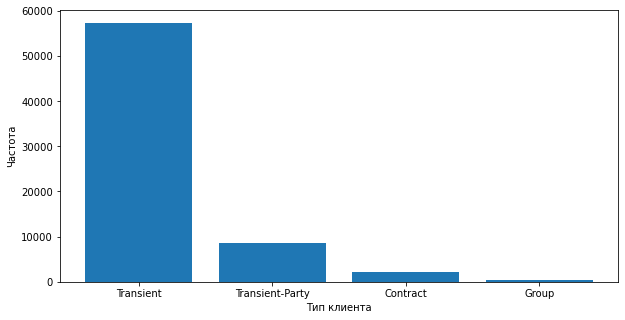

In [151]:
univ_bar(data_full,'customer_type',xlabel='Тип клиента')
plt.show()

In [152]:
multi_crosstab(data_full,'customer_type')

customer_type,Contract,Group,Transient,Transient-Party
is_canceled,,,,
0,3.62%,0.79%,81.02%,14.57%
1,2.18%,0.14%,90.49%,7.19%
diff,-1.44%,-0.64%,9.47%,-7.39%


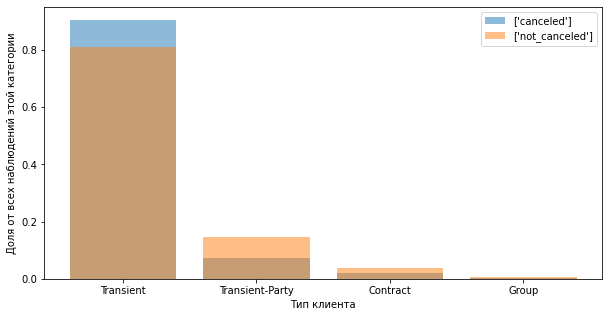

In [153]:
multiv_target_bar_normalized(data_full,'customer_type',xlabel='Тип клиента',sort=True)
plt.show()

**Вывод**
* Разница:
	* Transient - на ~9% выше шанс отмены
	* Transient-Party - на ~7% ниже шанс отмены

#### 'required_car_parking_spaces'

In [154]:
univ_cat_describe(data_full,'required_car_parking_spaces')

,count,proportion
value,,
0,63499,0.9264
1,5027,0.0733
2,17,0.0002
3,2,0.0000
8,2,0.0000


In [155]:
univ_quant_describe(data_full,'required_car_parking_spaces')

,required_car_parking_spaces
count,68547.000
mean,0.074
mode,0.000
var,0.071
stddev,0.266
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,8.000


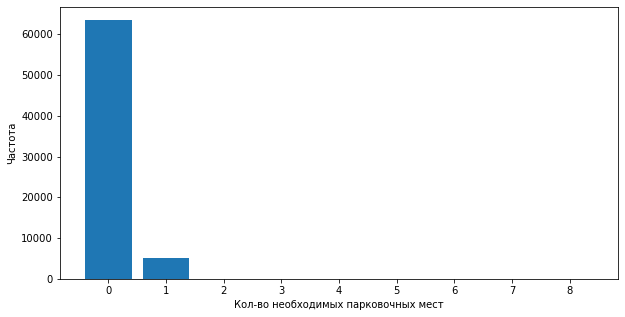

In [156]:
univ_bar(data_full,'required_car_parking_spaces',xlabel='Кол-во необходимых парковочных мест')
plt.show()

In [157]:
multi_crosstab(data_full,'required_car_parking_spaces')

required_car_parking_spaces,0,1,2,3,8
is_canceled,,,,,
0,89.83%,10.13%,0.03%,0.00%,0.00%
1,100.00%,0.00%,0.00%,0.00%,0.00%
diff,10.17%,-10.13%,-0.03%,-0.00%,-0.00%


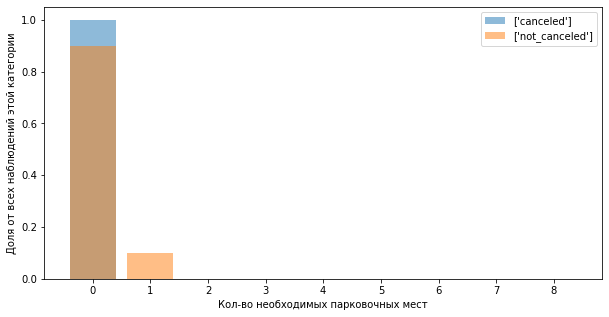

In [158]:
multiv_target_bar_normalized(data_full,'required_car_parking_spaces',xlabel='Кол-во необходимых парковочных мест')
plt.show()

**Вывод**
* Выбросы (>0) 5048 (7%)
* Здесь совершенно отсутствую наблюдения >0 в подклассе без-отмены. Т.е. 100% всех отмен этого признака попадают в значение 0. 


#### 'total_of_special_requests'

In [159]:
univ_cat_describe(data_full,'total_of_special_requests')

,count,proportion
value,,
0,33920,0.4948
1,23275,0.3395
2,9331,0.1361
3,1781,0.0260
4,213,0.0031
5,27,0.0004


In [160]:
univ_quant_describe(data_full,'total_of_special_requests')

,total_of_special_requests
count,68547.000
mean,0.704
mode,0.000
var,0.682
stddev,0.826
min,0.000
25%,0.000
50%,1.000
75%,1.000
max,5.000


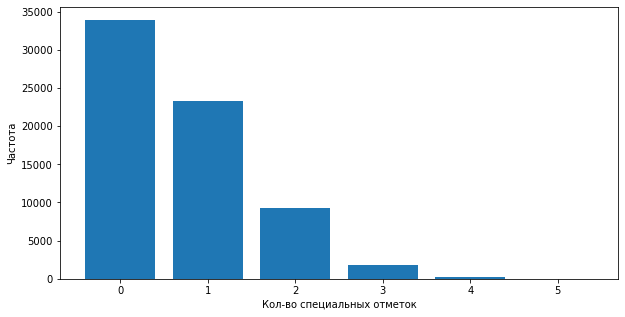

In [161]:
univ_bar(data_full,'total_of_special_requests',xlabel='Кол-во специальных отметок')
plt.show()

In [162]:
multi_crosstab(data_full,'total_of_special_requests')

total_of_special_requests,0,1,2,3,4,5
is_canceled,,,,,,
0,45.27%,36.54%,14.81%,2.94%,0.38%,0.05%
1,60.52%,27.17%,10.48%,1.69%,0.13%,0.01%
diff,15.25%,-9.37%,-4.33%,-1.25%,-0.25%,-0.05%


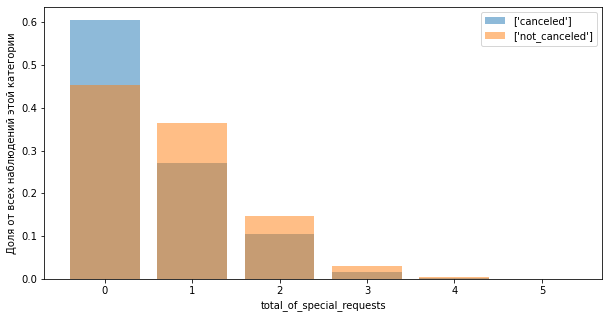

In [163]:
multiv_target_bar_normalized(data_full,'total_of_special_requests')
plt.show()

**Вывод**
* Выбросы (>2.5) 2021 (3%)
* Разница:
	* Кол-во спец. отметок = 0 - на ~15% выше шанс отмены
	* 1 - на ~9% ниже шанс
	* 2 - на ~4% ниже шанс.

#### Таблица корреляции признаков друг с другом

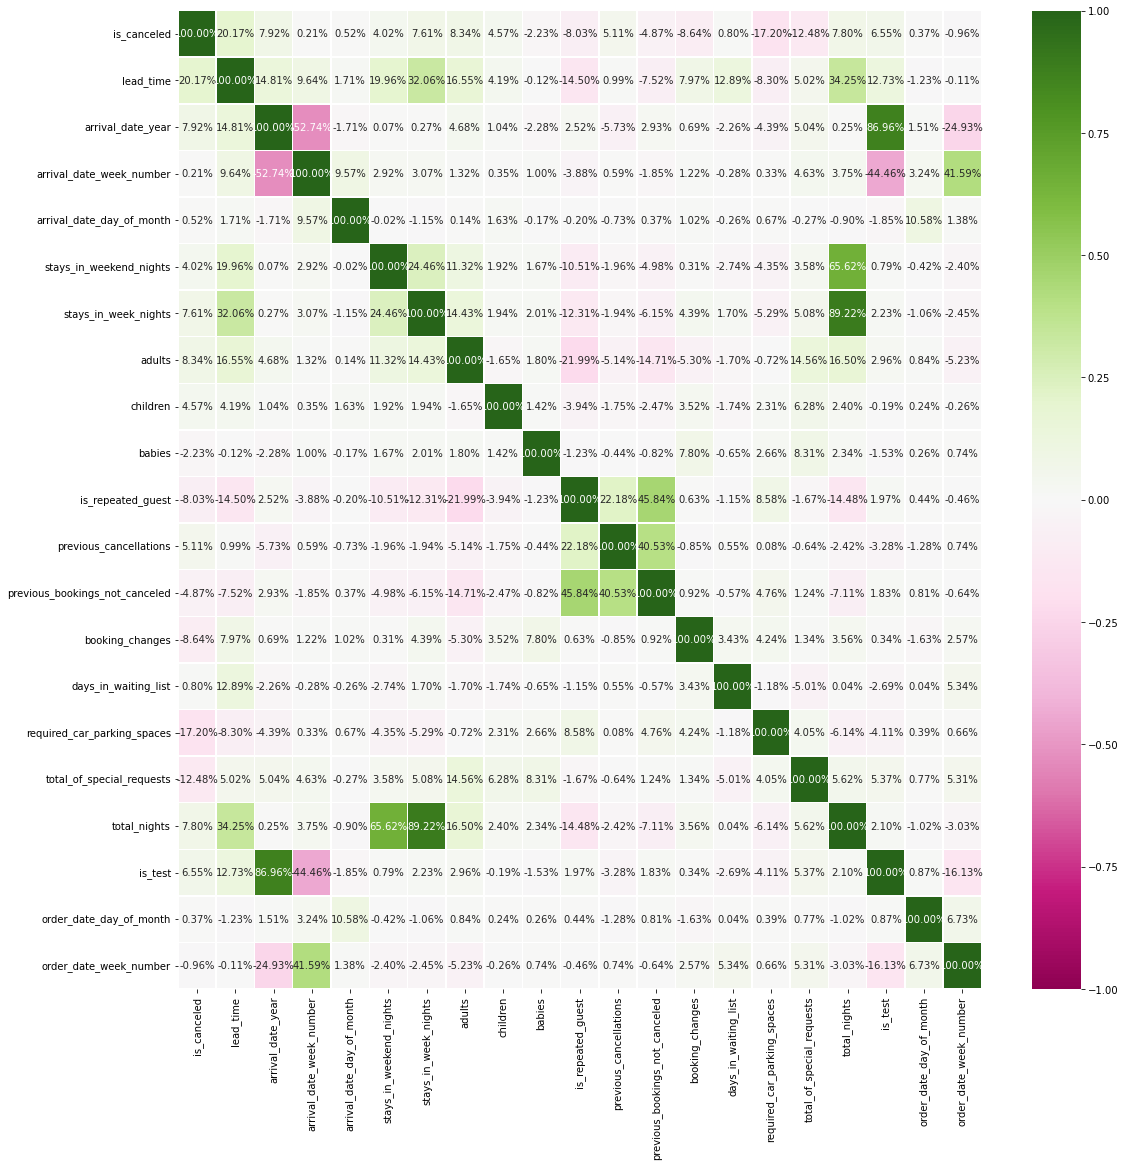

In [204]:
fig,ax = plt.subplots(figsize=(18,18))
sns.heatmap(data_full.corr(), annot=True,ax=ax,vmin=-1,vmax=1,linewidth=.5,cmap="PiYG",center=0,fmt='.2%')
plt.show()

**Вывод**
Признаки со средней корреляцией (0.5 - 0.7):

* `'total_night'` `'stays_in_weekend_nights'` 0.62

Признаки с высокой корреляцией (0.7 - 0.9):

* `'total_night'` `'stays_in_week_nights'` 0.89
* `'is_test'` `'arrival_date_year'` 0.86


#### Вывод по анализу

`'is_canceled'`
* Дисбаланс целевого признака
* Отметим относительно высокую корреляцию с `'lead_time'`,`'previous_cancellations'`,`'booking_changes'`,`'required_car_parking_spaces'`,`'total_of_special_requests'`.

`'lead_time'`
* Где-то до 20 дней шанс отмены значительно ниже
* От 20 и далее шанс отмены чуть выше.
* Выбросов (>278 дней) 1796 (2,6%)

Изучение дат

`'arrival_date_year'`

* Кол-во наблюдений в трейне за 2015 год == 9,8к, за 2016 == 34к

`'arrival_date_month'`

* Реже отменяют бронь в январе, феврале, марте,, сентябре, октябре, ноябре.
* Чаще отменяют бронь в сезон: с апреля по август.

`'arrival_date_week_number'`

* Наблюдения за 2015 год есть только с середины до конца года и это распределение визуально отличается от распределения того же периода за 2016 год.
* По отменам брони картина повторяет месячную. Весной и летом отменяют чаще. И последняя неделя - тоже больше шанс отмены.

`'order_date_month'`

* Чаще бронируют с января по март.
* Значимых различий по шансу отмены - нет.

`'order_date_week_number'`

* Повторяет картину с месяцами ордера.
* Значимых различий по шансу отмены - нет.

Изучение длительности пребывания

`'stays_in_weekend_nights'`

* Выбросов нет.
* Редко кто бронирует на 3 и 4 выходных ночей (0.5%,0.4%)
* Разница:
	* 0 ночь в выходнеы ~4% меньше шанс отмены 
	* 2 ночи ~3% выше шанс

`'stays_in_week_nights'`

* Выбросов нет.
* Разница: 
	* 0 ночей в будни (значит бронировалось только в выходные) на ~2% ниже шанс отмены брони
	* 1 ночь в будни - ~6% ниже шанс отмены
	* от 2х до 5 ночей в будни - ~2% выше шанс отмены
    
`'total_nights'`

* Выбросы (>7 дней) 1025 (1,5%)
* Разница:
	* 1 ночь ~9% меньше шанс отмены 
	* 3 ночи ~3% выше шанс
	* 4 ночи ~3% выше шанс

Изучение состава и кол-ва постояльцев

`'adults'`

* Выбросы (>2) 17712 (20%)
* Можно ли сдавать номера исключительно детям? В некоторых наблюдениях 'adults'==0
* Разница:
	* 1 взрослый - ~8% ниже шанс отмены брони
	* 2 взрослых - ~6% выше шанс отмены брони

`'children'`

* Выбросы (>0) 5349 (7%)
* Чаще без детей. (92%)
* По отменам существенной разницы нет.

`'babies'`

* Выбросы (>0) 623 (0.9%)
* Чаще без младенцев. (99%)
* По отменам существенной разницы нет.
* Есть подозрительные значения 9 и 10. <- можно убрать

`'meal'`
* BB - на ~5% ниже шанс отмены.
* SC - на ~5% выше шанс отмены

`'country'`
* 174 уникальных значения
* 13 стран имеют наблюдений больше 1000
* Клиенты из Португалии имеют на ~11% больше вероятность отменить бронь.

`'distribution_channel'`
* 80% - приходится на TA/TO
* Разница:
	* TA/TO - на ~13% выше шанс отмены
	* Direct - на ~9% ниже шанс
	* Corporate - на ~4% ниже шанс

`'is_repeated_guest'`
* Можно сказать, что повторный клиент с меньшим на ~3% шансом отменит бронь.

Изучение истории отмен/не-отмен  

`'previous_cancellations'`  

* Выбросы (>0) 1374 (2%)
* Здесь 98% всех наблюдений приходится на 0. При этом более 99% не-отмен приходится именно на 0. Стоит проверить модель с этим признаком и без него.

`'previous_bookings_not_canceled'`  

* Выбросы (>0) 2514 (4%)
* Здесь подобная ситуация (96% приходится на 0), но разница между подгруппами по таргету менее выражена. (Не более 4.12%)

`'reserved_room_type'`
* Разница: 
	* А - На ~4% выше шанс отмены
	* D - На ~3% ниже шанс отмены

`'booking_changes'`

* Выбросы (>0) 11668 (17%)
* Разница:
	* Количество изменений параметров заказа 0 - на 10% выше шанс отмены
	* 1 - на ~8% ниже шанс

`'days_in_waiting_list'`

* Выбросы (>0) 655 (1%)
* 99% всех наблюдений приходится на 0

`'customer_type'`
* Разница:
	* Transient - на ~9% выше шанс отмены
	* Transient-Party - на ~7% ниже шанс отмены

`'required_car_parking_spaces'`
* Выбросы (>0) 5048 (7%)
* Здесь совершенно отсутствую наблюдения >0 в подклассе без-отмены. Т.е. 100% всех отмен этого признака попадают в значение 0.

`'total_of_special_requests'`
* Выбросы (>2.5) 2021 (3%)
* Разница:
	* Кол-во спец. отметок = 0 - на ~15% выше шанс отмены
	* 1 - на ~9% ниже шанс
	* 2 - на ~4% ниже шанс.

Корреляции признаков

Признаки со средней корреляцией (0.5 - 0.7):

* `'total_night'` `'stays_in_weekend_nights'` 0.62

Признаки с высокой корреляцией (0.7 - 0.9):

* `'total_night'` `'stays_in_week_nights'` 0.89
* `'is_test'` `'arrival_date_year'` 0.86

## Алгоритм подсчета выручки

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
* категория `A`: за ночь — 1 000, разовое обслуживание — 400;
* категория `B`: за ночь — 800, разовое обслуживание — 350;
* категория `C`: за ночь — 600, разовое обслуживание — 350;
* категория `D`: за ночь — 550, разовое обслуживание — 150;
* категория `E`: за ночь — 500, разовое обслуживание — 150;
* категория `F`: за ночь — 450, разовое обслуживание — 150;
* категория `G`: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

In [165]:
room_rate = {"A": [1000,400],
             "B": [800,350],
             "C": [600,350],
             "D": [550,150],
             "E": [500,150],
             "F": [450,150],
             "G": [350,150]}

In [166]:
# <<<<
# Функция долгая, но работает :)
# <<<<

def revenue(row):
    """
    Алгоритм подсчета выручки, который на вход принимает строку, выдает - стоимость заказа для клиента.
    """
#     Для подсчета нам нужна информация об отмене брони,
#     дате приезда, типе комнаты и общем количестве дней.
    cols = ['is_canceled',
            'arrival_date_year', 
            'arrival_date_month', 
            'arrival_date_day_of_month', 
            'reserved_room_type', 
            'total_nights']
#   Создаем копию столбца, чтобы не изменять оригинал
    row = row[cols].copy()
    
#   Период заказа может приходится на разные сезоны, поэтому нужно посчитать кол-во дней каждого сезона
#   Для этого посчитаем дату прибытия
    row['arrival_date'] = row['arrival_date_year'], row['arrival_date_month'], row['arrival_date_day_of_month']
    row['arrival_date'] = '-'.join([str(x) for x in row['arrival_date']])
    row['arrival_date'] = pd.to_datetime(row['arrival_date'],format="%Y-%B-%d")
    
#   После подсчета удалим ненужные столбцы  
    row = row.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'])
    
#   Создадим счетчики для дней сезонов
    row['winter_days'] = 0
    row['spring_days'] = 0
    row['summer_days'] = 0
    row['fall_days'] = 0
    
#   Посчитаем дату съезда
    row['departure_date'] = row['arrival_date'] + pd.to_timedelta(row['total_nights'],unit='D')
    
#   Если месяц приходится на определенный сезон, то добавляем 1 в соответсвующий счетчик
    date = row['arrival_date']
    for n in range(row['total_nights']):
        if date.month in [12,1,2]:
            row['winter_days'] += 1
        elif date.month in [3,4,5]:
            row['spring_days'] += 1
        elif date.month in [6,7,8]:
            row['summer_days'] += 1
        elif date.month in [9,10,11]:
            row['fall_days'] += 1
        date = date + pd.to_timedelta(1,unit='D')
        
#   Из-за этой ^ конструкции функция выполняется очень долго.
#   В целом, стоит переписать ее пользуясь исключительно средствами пандаса или нампая


# #   Словарь с типом комнаты, стоимостью ночи и стоимостью обслуживания
#     room_rate = {"A": [1000,400],
#                  "B": [800,350],
#                  "C": [600,350],
#                  "D": [550,150],
#                  "E": [500,150],
#                  "F": [450,150],
#                  "G": [350,150]}
    
    
    row['reserved_room_type'] = row['reserved_room_type'].strip() # Функция очистки строки, на всякий случай
    row['night_rate'] = room_rate[row['reserved_room_type']][0] # Создание переменной со стоимостью ночи с учетом типа комнаты
    row['service_cost'] = room_rate[row['reserved_room_type']][1] # Создание переменной со стоимостью ночи с учетом типа комнаты
    
#   Подсчет стоимости всех ночей с учетом сезона
    row['total_nights_cost'] =  ((row['winter_days']) + (row['spring_days'] * 1.2) + (row['summer_days'] * 1.4) + (row['fall_days'] * 1.2)) * row['night_rate']
#   Подсчет стоимости обслуживания номера (раз в 2 дня)
    row['total_service_costs'] = np.ceil(row['total_nights'] / 2) * row['service_cost']
#   Подсчет общей вырчуки    
    row['total_revenue'] = row['total_nights_cost'] - row['total_service_costs']
    
    
#   Если была отмена брони, то выручка == 0
    if row['is_canceled'] == 1:
        row['total_revenue'] = - row['service_cost']
            
    return row['total_revenue']



# Создадим столбец в тестовых данных с выручкой за заказ
data_test['revenue_without_prediction'] = data_test.apply(lambda row: revenue(row),axis=1)
display(data_test.head())

# Подсчитаем общую выручку за год
total_revenue_raw =  data_test['revenue_without_prediction'].sum() # 57192000.0
print('Общая выручка за год:', total_revenue_raw)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,is_test,revenue_without_prediction
id,,,,,,,,,,,,,,,,,,,,,,,,,,
6086,1,74.0000,2017,January,1,1,1,0,2.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1,-400.0000
6087,1,62.0000,2017,January,1,1,2,2,2.0000,0.0000,0.0000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1,-400.0000
6089,1,71.0000,2017,January,1,1,2,2,1.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1,-400.0000
6090,1,172.0000,2017,January,1,1,2,5,2.0000,0.0000,0.0000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1,-400.0000
6091,1,52.0000,2017,January,1,1,2,5,1.0000,0.0000,0.0000,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1,-400.0000


Общая выручка за год: 43036070.0


## Выбор и обучение модели ML

### Подготовка данных

Поскольку для обучения и тестирования модели мы используем `data_train` и `data_test`, а анализировали `data_full`, то нужно добавить некоторые признаки в эти два датасета.

Нам понадобятся признаки даты ордера, а именно `order_date_week_number`,`order_date_month`,`order_date_day_of_month`.

Также используем sin-cos преобразование для цикличных признаков, которые отражают сезонность: `'arrival_date_month'`, `'arrival_date_week_number'`, `'order_date_month'`, `'order_date_day_of_month'`

И заменим страны, встречающиеся менее 1000 раз на группу `other`.

Все численные признаки нормализуем, категориальные - OneHotEncode

Также, попробуем проверить эффективность моделей с и без признаков: `'previous_cancellations'`, `'required_car_parking_spaces'`.

**План**
1. Создать `'order_date_week_number'`,`'order_date_month'`,`'order_date_day_of_month'`
2. Sin,cos преобразование `'arrival_date_month'`, `'arrival_date_week_number'`, `'order_date_month'`, `'order_date_day_of_month'`
3. Нормализация
4. Замена Country<1000 на other
5. OHE

In [167]:
data_train.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights', 'is_test'],
      dtype='object')

In [168]:
X_train = data_train.drop(columns=['is_canceled','is_test'])
y_train = data_train['is_canceled']

In [170]:
X_train.columns

Index(['lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights'],
      dtype='object')

In [171]:
X_test = data_test.drop(columns=['is_canceled','is_test'])
y_test = data_test['is_canceled']

In [172]:
# Создадим новые фичи order_date_week_number,order_date_month,order_date_day_of_month
def order_date(df):
    var1 = pd.to_datetime(df[['arrival_date_year','arrival_date_month','arrival_date_day_of_month']].astype(str).apply(lambda x: '-'.join(x),axis=1),format="%Y-%B-%d")
    var2 = pd.to_timedelta(df['lead_time'],unit='D')

    order_date = var1 - var2

    df['order_date_month'] = order_date.dt.month
    df['order_date_day_of_month'] = order_date.dt.day
    df['order_date_week_number'] = order_date.dt.week

order_date(X_train)
order_date(X_test)

<ipython-input-172-b4c470239e8c>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['order_date_week_number'] = order_date.dt.week


In [173]:
# Можем удалить arrival_date_year
X_train = X_train.drop(columns = ['arrival_date_year'])
display(X_train.head())
X_test = X_test.drop(columns = ['arrival_date_year'])
X_test.head()

,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,order_date_month,order_date_day_of_month,order_date_week_number
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,7.0000,July,27,1,0,1,1.0000,0.0000,0.0000,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1,6,24,26
1,14.0000,July,27,1,0,2,2.0000,0.0000,0.0000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2,6,17,25
2,0.0000,July,27,1,0,2,2.0000,0.0000,0.0000,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2,7,1,27
3,9.0000,July,27,1,0,2,2.0000,0.0000,0.0000,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2,6,22,26
4,85.0000,July,27,1,0,3,2.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3,4,7,15


,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_without_prediction,order_date_month,order_date_day_of_month,order_date_week_number
id,,,,,,,,,,,,,,,,,,,,,,,,,,
6086,74.0000,January,1,1,1,0,2.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,-400.0000,10,19,42
6087,62.0000,January,1,1,2,2,2.0000,0.0000,0.0000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,-400.0000,10,31,44
6089,71.0000,January,1,1,2,2,1.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,-400.0000,10,22,42
6090,172.0000,January,1,1,2,5,2.0000,0.0000,0.0000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,-400.0000,7,13,28
6091,52.0000,January,1,1,2,5,1.0000,0.0000,0.0000,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,7,-400.0000,11,10,45


In [174]:
# Переведем месяцы прибытия в числовой тип
display(X_train['arrival_date_month'].head())
X_train['arrival_date_month'] = X_train['arrival_date_month'].cat.codes + 1
X_train['arrival_date_month'].head()

id
0    July
1    July
2    July
3    July
4    July
Name: arrival_date_month, dtype: category
Categories (12, object): ['January' < 'February' < 'March' < 'April' ... 'September' < 'October' < 'November' < 'December']

id
0    7
1    7
2    7
3    7
4    7
Name: arrival_date_month, dtype: int8

In [175]:
display(X_test['arrival_date_month'].head())
X_test['arrival_date_month'] = X_test['arrival_date_month'].cat.codes + 1
X_test['arrival_date_month'].head()

id
6086    January
6087    January
6089    January
6090    January
6091    January
Name: arrival_date_month, dtype: category
Categories (12, object): ['January' < 'February' < 'March' < 'April' ... 'September' < 'October' < 'November' < 'December']

id
6086    1
6087    1
6089    1
6090    1
6091    1
Name: arrival_date_month, dtype: int8

In [176]:
# Sin,cos преобразование для месяца (от 1 до 12) и номера недели (от 1 до 53)
def sin_cos_transf(df,column,n):
#     n = df[column].nunique()
    new_sin_name = column + "_sin"
    new_cos_name = column + "_cos"
    df[new_sin_name] = np.sin((df[column] - 1)*(2.*np.pi/n)) # df[column] - 1, чтобы отсчет начинался с 0
    df[new_cos_name] = np.cos((df[column] - 1)*(2.*np.pi/n)) 
    


In [177]:
months_to_sincos_transform = ['arrival_date_month', 'order_date_month']
weeks_n_to_sincos_transform = ['arrival_date_week_number', 'order_date_week_number']

for df in [X_train,X_test]:
    for col in months_to_sincos_transform:
        sin_cos_transf(df,col,12)
        
for df in [X_train,X_test]:
    for col in weeks_n_to_sincos_transform:
        sin_cos_transf(df,col,53)

In [178]:
X_train.columns,X_test.columns

(Index(['lead_time', 'arrival_date_month', 'arrival_date_week_number',
        'arrival_date_day_of_month', 'stays_in_weekend_nights',
        'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
        'country', 'distribution_channel', 'is_repeated_guest',
        'previous_cancellations', 'previous_bookings_not_canceled',
        'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
        'customer_type', 'required_car_parking_spaces',
        'total_of_special_requests', 'total_nights', 'order_date_month',
        'order_date_day_of_month', 'order_date_week_number',
        'arrival_date_month_sin', 'arrival_date_month_cos',
        'order_date_month_sin', 'order_date_month_cos',
        'arrival_date_week_number_sin', 'arrival_date_week_number_cos',
        'order_date_week_number_sin', 'order_date_week_number_cos'],
       dtype='object'),
 Index(['lead_time', 'arrival_date_month', 'arrival_date_week_number',
        'arrival_date_day_of_month', 'stays_in

In [179]:
# Удалим оригинальные столбцы
X_train = X_train.drop(columns=months_to_sincos_transform + weeks_n_to_sincos_transform)
X_test = X_test.drop(columns=months_to_sincos_transform + weeks_n_to_sincos_transform)

In [180]:
# Нормализация
# cols_to_normalize = ['lead_time', 'arrival_date_day_of_month',
#                     'stays_in_weekend_nights', 'stays_in_week_nights',
#                     'adults', 'children', 'babies', 
#                     'previous_bookings_not_canceled', 'booking_changes', 
#                     'days_in_waiting_list', 'total_of_special_requests', 
#                     'total_nights', 'order_date_day_of_month', 
#                     'arrival_date_month_sin', 'arrival_date_month_cos', 
#                     'arrival_date_week_number_sin', 'arrival_date_week_number_cos', 
#                     'order_date_month_sin', 'order_date_month_cos',
#                     'order_date_week_number_sin', 'order_date_week_number_cos']

cols_to_normalize = X_train.select_dtypes(exclude='object').columns

scaler = StandardScaler()
scaler.fit(X_train[cols_to_normalize])

X_train[cols_to_normalize] = scaler.transform(X_train[cols_to_normalize])
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])



In [181]:
# Замена стран с <1000 наблюдений на категорию other
countries_more_1000 = univ_cat_describe(data_full,'country',sort=True).query('count > 1000').index.to_list()
X_train.loc[~X_train['country'].isin(countries_more_1000),'country'] = 'other'
X_train['country'].value_counts()

PRT      14467
other     5888
FRA       4825
GBR       4274
ESP       3908
DEU       2754
ITA       1774
IRL       1236
BEL       1079
NLD       1033
BRA        948
USA        876
CHE        790
Name: country, dtype: int64

In [182]:
X_test.loc[~X_test['country'].isin(countries_more_1000),'country'] = 'other'
X_test['country'].value_counts()

PRT      5436
other    4029
GBR      3347
FRA      2988
DEU      1972
ESP      1629
ITA       947
IRL       932
BEL       783
BRA       777
USA       691
NLD       638
CHE       526
Name: country, dtype: int64

In [183]:
X_train.columns

Index(['lead_time', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights', 'order_date_day_of_month',
       'arrival_date_month_sin', 'arrival_date_month_cos',
       'order_date_month_sin', 'order_date_month_cos',
       'arrival_date_week_number_sin', 'arrival_date_week_number_cos',
       'order_date_week_number_sin', 'order_date_week_number_cos'],
      dtype='object')

In [184]:
X_train.select_dtypes(include='object').columns

Index(['meal', 'country', 'distribution_channel', 'reserved_room_type',
       'customer_type'],
      dtype='object')

In [185]:
# OHE

# cols_to_ohe = ['meal',
#                'country',
#                'distribution_channel',
#                'reserved_room_type',
#                'customer_type']

cols_to_ohe = X_train.select_dtypes(include='object').columns

ohe = OneHotEncoder(drop='first')
ohe.fit(X_train[cols_to_ohe])

X_train_cat_ohe = pd.DataFrame(ohe.transform(X_train[cols_to_ohe]).toarray(),columns=ohe.get_feature_names_out())
X_train = pd.concat([X_train.drop(columns=cols_to_ohe).reset_index(drop=True),X_train_cat_ohe],axis=1)
display(X_train.head())


,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,order_date_day_of_month,arrival_date_month_sin,arrival_date_month_cos,order_date_month_sin,order_date_month_cos,arrival_date_week_number_sin,arrival_date_week_number_cos,order_date_week_number_sin,order_date_week_number_cos,meal_FB,meal_HB,meal_SC,country_BRA,country_CHE,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ITA,country_NLD,country_PRT,country_USA,country_other,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.8230,-1.6841,-1.0327,-0.9019,-1.6960,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,-0.8355,-1.1763,1.0070,0.2126,-1.3623,0.7512,-1.3310,0.3169,-1.3926,0.2674,-1.5355,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
1,-0.7284,-1.6841,-1.0327,-0.2146,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,0.4099,-0.6436,0.2007,0.2126,-1.3623,0.7512,-1.3310,0.3169,-1.3926,0.4283,-1.4954,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,-0.9176,-1.6841,-1.0327,-0.2146,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,-0.8355,-0.6436,-1.6424,0.2126,-1.3623,0.0386,-1.5202,0.3169,-1.3926,0.1030,-1.5557,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
3,-0.7960,-1.6841,-1.0327,-0.2146,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,0.4099,-0.6436,0.7766,0.2126,-1.3623,0.7512,-1.3310,0.3169,-1.3926,0.2674,-1.5355,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
4,0.2312,-1.6841,-1.0327,0.4728,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,0.4099,-0.1109,-0.9513,0.2126,-1.3623,1.4639,-0.1078,0.3169,-1.3926,1.4117,-0.2443,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000


In [186]:
X_test_cat_ohe = pd.DataFrame(ohe.transform(X_test[cols_to_ohe]).toarray(),columns=ohe.get_feature_names_out())
X_test = pd.concat([X_test.drop(columns=cols_to_ohe).reset_index(drop=True),X_test_cat_ohe],axis=1)
X_test.head()

,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_without_prediction,order_date_day_of_month,arrival_date_month_sin,arrival_date_month_cos,order_date_month_sin,order_date_month_cos,arrival_date_week_number_sin,arrival_date_week_number_cos,order_date_week_number_sin,order_date_week_number_cos,meal_FB,meal_HB,meal_SC,country_BRA,country_CHE,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ITA,country_NLD,country_PRT,country_USA,country_other,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0.0825,-1.6841,0.1198,-1.5893,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,-0.8355,-1.1763,-400.0000,0.4311,0.2126,1.6349,-1.3868,-0.1078,0.2349,1.6064,-1.3614,0.0967,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
1,-0.0797,-1.6841,1.2724,-0.2146,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,0.4099,0.4218,-400.0000,1.8134,0.2126,1.6349,-1.3868,-0.1078,0.2349,1.6064,-1.2743,0.4258,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,0.0420,-1.6841,1.2724,-0.2146,-1.6960,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,0.4099,0.4218,-400.0000,0.7766,0.2126,1.6349,-1.3868,-0.1078,0.2349,1.6064,-1.3614,0.0967,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
3,1.4070,-1.6841,1.2724,1.8476,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,-0.8355,2.0200,-400.0000,-0.2601,0.2126,1.6349,0.0386,-1.5202,0.2349,1.6064,-0.0625,-1.5557,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
4,-0.2148,-1.6841,1.2724,1.8476,-1.6960,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,-0.8355,2.0200,-400.0000,-0.6057,0.2126,1.6349,-1.1958,0.5985,0.2349,1.6064,-1.2031,0.5800,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000


In [187]:
X_train.head()

,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,order_date_day_of_month,arrival_date_month_sin,arrival_date_month_cos,order_date_month_sin,order_date_month_cos,arrival_date_week_number_sin,arrival_date_week_number_cos,order_date_week_number_sin,order_date_week_number_cos,meal_FB,meal_HB,meal_SC,country_BRA,country_CHE,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ITA,country_NLD,country_PRT,country_USA,country_other,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.8230,-1.6841,-1.0327,-0.9019,-1.6960,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,-0.8355,-1.1763,1.0070,0.2126,-1.3623,0.7512,-1.3310,0.3169,-1.3926,0.2674,-1.5355,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
1,-0.7284,-1.6841,-1.0327,-0.2146,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,0.4099,-0.6436,0.2007,0.2126,-1.3623,0.7512,-1.3310,0.3169,-1.3926,0.4283,-1.4954,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,-0.9176,-1.6841,-1.0327,-0.2146,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,-0.8355,-0.6436,-1.6424,0.2126,-1.3623,0.0386,-1.5202,0.3169,-1.3926,0.1030,-1.5557,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
3,-0.7960,-1.6841,-1.0327,-0.2146,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,0.4099,-0.6436,0.7766,0.2126,-1.3623,0.7512,-1.3310,0.3169,-1.3926,0.2674,-1.5355,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
4,0.2312,-1.6841,-1.0327,0.4728,0.2846,-0.2709,-0.0891,-0.1845,-0.0907,-0.0977,-0.3670,-0.0829,-0.2983,0.4099,-0.1109,-0.9513,0.2126,-1.3623,1.4639,-0.1078,0.3169,-1.3926,1.4117,-0.2443,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000


### Выбор модели

Сравним логистическую регрессию и случайный лес.

В качестве метрики возьмем ROC AUC, поскольку эта метрика показывает результативность модели без учета порогового значения классификации.

И это пороговое значение будем подбирать, чтобы учесть дисбаланс классов.

Вместе с этим проверим результативность моделей с и без признаков: `'previous_cancellations'`, `'required_car_parking_spaces'`.

In [188]:
# def roc_curve_plot(target,probabilities_one):
#     """
#     Функция строит ROC-кривую
#     """
#     # Получим значения FPR и TPR для построения графика
#     fpr, tpr, thresholds = roc_curve(target,probabilities_one)

#     plt.figure()

#     plt.plot(fpr,tpr)

#     # ROC-кривая случайной модели (выглядит как прямая)
#     plt.plot([0, 1], [0, 1], linestyle='--')

#     plt.xlim([0,1])
#     plt.ylim([0,1])

#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")

#     plt.title("ROC-кривая")

#     plt.show()

Создадим выборки с разным набором признаков.

In [189]:
# First bool 'previous_cancellations'
# Second bool 'required_car_parking_spaces'
X_train_full = X_train
X_train_1_0 = X_train.drop(columns=['required_car_parking_spaces'])
X_train_0_1 = X_train.drop(columns=['previous_cancellations'])
X_train_0_0 = X_train.drop(columns=['required_car_parking_spaces','previous_cancellations'])
X_train_full.columns,X_train_1_0.columns,X_train_0_1.columns,X_train_0_0.columns

(Index(['lead_time', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
        'stays_in_week_nights', 'adults', 'children', 'babies',
        'is_repeated_guest', 'previous_cancellations',
        'previous_bookings_not_canceled', 'booking_changes',
        'days_in_waiting_list', 'required_car_parking_spaces',
        'total_of_special_requests', 'total_nights', 'order_date_day_of_month',
        'arrival_date_month_sin', 'arrival_date_month_cos',
        'order_date_month_sin', 'order_date_month_cos',
        'arrival_date_week_number_sin', 'arrival_date_week_number_cos',
        'order_date_week_number_sin', 'order_date_week_number_cos', 'meal_FB',
        'meal_HB', 'meal_SC', 'country_BRA', 'country_CHE', 'country_DEU',
        'country_ESP', 'country_FRA', 'country_GBR', 'country_IRL',
        'country_ITA', 'country_NLD', 'country_PRT', 'country_USA',
        'country_other', 'distribution_channel_Direct',
        'distribution_channel_GDS', 'distribution_channel_TA/TO',


Найдем гиперпараметры для логистической регрессии используя разные алгоритмы вычисления и силу регуляризации.

In [190]:
def multi_fit(model):
    with warnings.catch_warnings(record=True):
        model.fit(X_train_full,y_train)
        print('X_train_full:',model.best_score_,model.best_params_)

        model.fit(X_train_1_0,y_train)
        print('X_train_1_0:',model.best_score_,model.best_params_)

        model.fit(X_train_0_1,y_train)
        print('X_train_0_1:',model.best_score_,model.best_params_)

        model.fit(X_train_0_0,y_train)
        print('X_train_0_0:',model.best_score_,model.best_params_)

In [191]:
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'C': np.logspace(0,4,num=10)}

logreg = GridSearchCV(LogisticRegression(), 
                           params, 
                           scoring = 'roc_auc', 
                           cv = 5,
                           verbose = 0)




# IN: multi_fit(logreg)

# OUT:
# X_train_full: 0.6776564463107256 {'C': 3593.813663804626, 'solver': 'lbfgs'}
# X_train_1_0: 0.6472091087421429 {'C': 166.81005372000593, 'solver': 'lbfgs'}
# X_train_0_1: 0.665871929279446 {'C': 7.742636826811269, 'solver': 'lbfgs'}
# X_train_0_0: 0.635355773008708 {'C': 2.7825594022071245, 'solver': 'lbfgs'}

In [192]:
# probabilities = logreg.predict_proba(X_train)[:,1]
# roc_curve_plot(y_train,probabilities)
# print('roc_auc_score:', roc_auc_score(y_train,probabilities))

Найдем гиперпараметры случайного леса.

In [193]:
params = {"n_estimators":[int(x) for x in np.linspace(1,1000,10)],
          "max_depth":[int(x) for x in np.linspace(1,100,10)],
          'random_state': [rand_state]}

rforest = RandomizedSearchCV(RandomForestClassifier(), 
                           params, 
                           scoring = 'roc_auc',
                           cv = 5, # cv=5
                           n_iter=100, 
                           verbose = 0,
                           random_state=rand_state,
                            n_jobs=-1)

# IN: multi_fit(rforest)

# OUT:
# X_train_full: 0.5698262346217213 {'random_state': 12345, 'n_estimators': 112, 'max_depth': 1}
# X_train_1_0: 0.5657998769380636 {'random_state': 12345, 'n_estimators': 1, 'max_depth': 1}
# X_train_0_1: 0.5657998769380636 {'random_state': 12345, 'n_estimators': 1, 'max_depth': 1}
# X_train_0_0: 0.527096009001881 {'random_state': 12345, 'n_estimators': 112, 'max_depth': 1}

Лучший результат показала логистическая регрессия.
Подберем порог классификации для компенсации дисбаланса.

In [194]:
# Обучим лучшую модель логистической регрессии
logreg = LogisticRegression(C=3593.813663804626,solver='lbfgs').fit(X_train_full,y_train)

c:\Users\SnakeRZR\Desktop\sample_project_1\enc\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [195]:
kf = KFold(n_splits=5, shuffle=True, random_state=rand_state)

scores = []
X = X_train_full
y = y_train.reset_index(drop=True)
for threshold in np.linspace(0.01,0.99,101):
    t_score = [] #<<< лист со скорами 1 трешхолда
    for train_index, test_index in kf.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)    
        X_tr, X_te = X.loc[train_index], X.loc[test_index]
        y_tr, y_te = y.loc[train_index], y.loc[test_index]
        with warnings.catch_warnings(record=True):
            lr = LogisticRegression(C=3593.813663804626,solver='lbfgs').fit(X_tr,y_tr)
#         display(y_te)
        predict_proba = lr.predict_proba(X_te)[:,1]
        score = f1_score(y_te, predict_proba > threshold)
        t_score.append(score)
    scores.append([threshold, np.array(t_score).mean()]) #<<< усреднение скоров
    
scores = pd.DataFrame(scores,columns=['threshold','f1'])
i = scores['f1'].argmax()
print('best threshold', scores.loc[i,'threshold'], 'best f1', scores.loc[i,'f1'])

# OUT: best threshold 0.2942 best f1 0.5714955266824086

best threshold 0.2942 best f1 0.5714955266824086


### Расчет эффективности модели по выручке

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Для подсчета разницы создадим столбец с выручкой при использовании модели.
Если была отмена брони и модель предсказала отмену, то в выручку записываем размер депозита, равный 80% от стоимости номера за одни сутки и затрат на разовую уборку.

In [196]:
# Создаем столбец с предиктами
probs_one = logreg.predict_proba(X_test.drop(columns='revenue_without_prediction'))[:,1]
prediction = probs_one > 0.2942
data_test['prediction'] = prediction


In [197]:
def reservation_fee(row):
    '''
    Если была отмена брони и модель предсказала отмену, то возвращаем 80% от стоимости номера за ночь и стоимость разовой уборки.
    '''
#     room_rate = {"A": [1000,400],
#              "B": [800,350],
#              "C": [600,350],
#              "D": [550,150],
#              "E": [500,150],
#              "F": [450,150],
#              "G": [350,150]}
    if row['is_canceled'] == 1 and row['prediction'] == True:
        result = sum(room_rate[row['reserved_room_type']]) * 0.8
        return result
    else:
        return 0

In [198]:
# Создадим столбец
data_test['reservation_fee'] = data_test.apply(lambda row: reservation_fee(row),axis=1)
data_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,is_test,revenue_without_prediction,prediction,reservation_fee
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6086,1,74.0000,2017,January,1,1,1,0,2.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1,-400.0000,True,"1,120.0000"
6087,1,62.0000,2017,January,1,1,2,2,2.0000,0.0000,0.0000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1,-400.0000,False,0.0000
6089,1,71.0000,2017,January,1,1,2,2,1.0000,0.0000,0.0000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1,-400.0000,True,"1,120.0000"
6090,1,172.0000,2017,January,1,1,2,5,2.0000,0.0000,0.0000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1,-400.0000,True,"1,120.0000"
6091,1,52.0000,2017,January,1,1,2,5,1.0000,0.0000,0.0000,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1,-400.0000,False,0.0000


Подсчитаем общую выручку с использованием модели, сложив выручку без модели и депозит.

In [199]:
# Подсчитаем общую выручку с использованием модели
total_revenue = data_test['revenue_without_prediction'].sum() + data_test['reservation_fee'].sum()
print('Общая выручка с использованием модели',total_revenue)

Общая выручка с использованием модели 47456590.0


Подсчитаем разницу выручек с учетом стоимости разработки модели.

In [200]:
print('Добавочная выручка:',total_revenue - total_revenue_raw - 400000)

Добавочная выручка: 4020520.0


**Вывод**

Модель определенно окупается.

## Портрет "ненадежного" клиента

### Интерпретация модели

Логистическая регрессия вычисляет коэффициенты признаков, определяя их "веса". 
Коэффициенты признаков можно интерпретировать, как изменение в положительную или отрицательную сторону шанса того, что конкретное наблюдение "выпадет" классом 1 при условии, что коэффициенты остальных признаков равны 0, т.е. не при прочих равных.

Построим таблицу с коэффициентами и изменением шанса в процентах.

In [201]:
coefs = np.reshape(logreg.coef_,(51,1))
fc = X_train_full.columns
feature_importances = (pd.DataFrame(coefs, index=fc,columns=['coef'])
                       .sort_values(['coef'],ascending=False))
feature_importances['odds_change'] = ((np.exp(feature_importances['coef']) - 1) * 100.).astype(int).astype(str) + '%'
feature_importances

,coef,odds_change
country_PRT,1.4849,341%
country_ITA,0.9271,152%
country_BRA,0.9222,151%
distribution_channel_TA/TO,0.8514,134%
customer_type_Transient,0.6991,101%
country_ESP,0.6783,97%
previous_cancellations,0.5664,76%
lead_time,0.5391,71%
meal_SC,0.5310,70%
reserved_room_type_B,0.5030,65%


Отдельно посмотрим самые влиятельные признаки в положительную и отрицательную сторону.

In [202]:
odds_int = ((np.exp(feature_importances['coef']) - 1) * 100.).astype(int)
odds_int_pos = odds_int[odds_int > 15]
odds_int_neg = odds_int[odds_int < -15].sort_values(ascending=True)
odds_int_pos,odds_int_neg

(country_PRT                     341
 country_ITA                     152
 country_BRA                     151
 distribution_channel_TA/TO      134
 customer_type_Transient         101
 country_ESP                      97
 previous_cancellations           76
 lead_time                        71
 meal_SC                          70
 reserved_room_type_B             65
 country_other                    62
 distribution_channel_GDS         58
 reserved_room_type_D             42
 order_date_month_cos             39
 country_USA                      33
 arrival_date_week_number_cos     25
 order_date_week_number_sin       23
 reserved_room_type_F             19
 arrival_date_month_sin           16
 Name: coef, dtype: int32,
 required_car_parking_spaces      -97
 customer_type_Group              -51
 order_date_week_number_cos       -44
 total_of_special_requests        -39
 previous_bookings_not_canceled   -38
 reserved_room_type_C             -35
 customer_type_Transient-Party    -29
 mea

Построим график для наглядности.

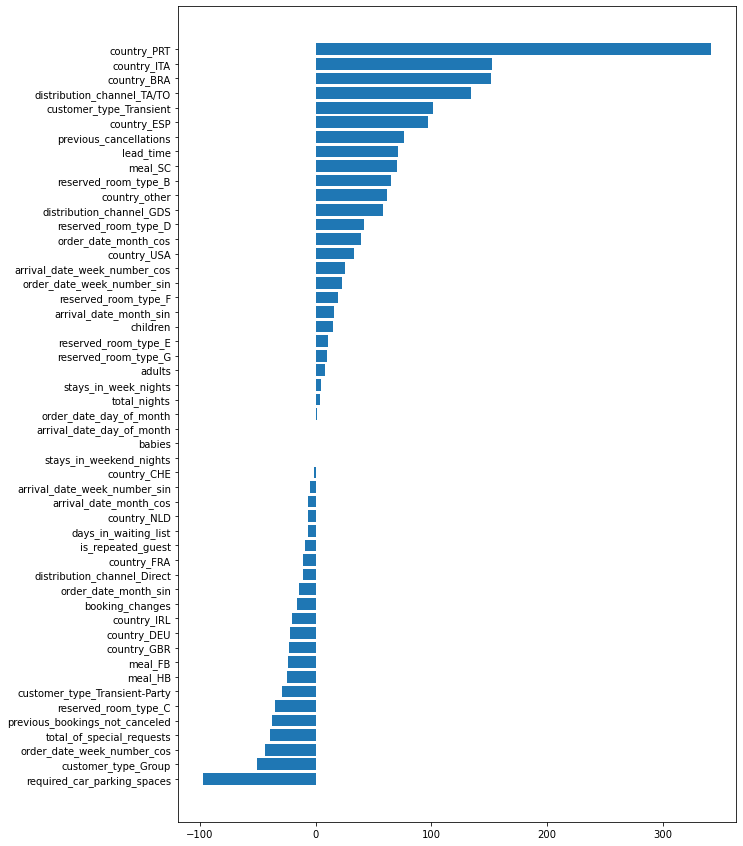

In [203]:
# feature_importances.plot.barh(figsize=(10,20))

odds_int = ((np.exp(feature_importances['coef']) - 1) * 100.).astype(int)

fig,ax = plt.subplots(figsize=(10,15))


ax.barh(feature_importances.index,odds_int)
# ax.tick_params('x',rotation=90)
ax.invert_yaxis()
plt.show()

### Вывод

На основе исследовательского анализа данных:

Чаще пара (adults == 2) из Португалии бронирует на дату через не менее 70 дней, на 2-3 ночи, на весну, лето, осень, пришедшие через TA/TO канал дистрибьюции.
Новые клиенты, выбирают комнату типа А, тип заказчика: "Transient", без специльных запросов.

На основе важности признаков в логистической регрессии:

Из Португалии/Италии/Бразилии с длительным временем между бронированием и заездом, канал дистрибьюции TA/TO, включен завтрак обед и ужин.

## Шаг 6. Напишите общий вывод

Для задачи классификации была выбрана модель логистической регресии, которая принесла дополнительную прибыль в 4,7 млн.

Базовая прибыль за 2017 год без применения модели = 43036070

С моделью = 47740670

Разница = 4704600

Разница с учетом затрат на разработку модели = 4304600

Модель определила следующие признаки, повышающие шанс на отмену брони:

|                              |   Повышается шанс на отмену брони в % |
|:-----------------------------|-------:|
| Из Португалии                |    341 |
| Из Италии                    |    152 |
| Из Бразилии                  |    151 |
| Канал дистрибьюции заказа=TA/TO   |    134 |
| Тип клиента=Transient        |    101 |
| Из Испании                   |     97 |
| Кол-во пред. отмен           |     76 |
| количество дней между датой бронирования и датой прибытия  |     71 |
| Еда не включена              |     70 |
| Тип комнаты=B                |     65 |
| Из редко встречающихся стран |     62 |
| Канал дистрибьюции заказа=GDS|     58 |
| Тип комнаты=D                |     42 |
| Месяц ордера на бронь        |     39 |
| Из США                       |     33 |
| Номер недели прибытия        |     25 |
| Номер нелели ордера          |     23 |
| Тип комнаты=D                |     19 |
| Месяц прибытия               |     16 |

И следующий признаки, понижающие шанс на отмену брони:


|                                |   Изменяется шанс на отмену брони в % |
|:-------------------------------|-------:|
| Необходимое кол-во парковочных мест    |    -97 |
| Тип клиента=Group              |    -51 |
| Номер недели ордера            |    -44 |
| количество специальных отметок |    -39 |
| Не было предыдущих отмен       |    -38 |
| Тип комнаты=C                  |    -35 |
| Тип клиента=Transient-Party    |    -29 |
| включён завтрак и обед         |    -25 |
| включён завтрак, обед и ужин   |    -24 |
| Из Великобритании              |    -23 |
| Из Германии                    |    -22 |
| Из Ирландии                    |    -20 |
| Изменения в заказе             |    -16 |


Используемые признаки при обучении модели: 
```
'lead_time', 'arrival_date_year', 'arrival_date_month',
'arrival_date_week_number', 'arrival_date_day_of_month',
'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
'babies', 'meal', 'country', 'distribution_channel',
'is_repeated_guest', 'previous_cancellations',
'previous_bookings_not_canceled', 'reserved_room_type',
'booking_changes', 'days_in_waiting_list', 'customer_type',
'required_car_parking_spaces', 'total_of_special_requests',
'total_nights'
```